# Analytics - query to reference mapping  

This notebook is based on and adapted from this scvi-tools tutorial: https://docs.scvi-tools.org/en/stable/tutorials/notebooks/query_hlca_knn.html

In [2]:
import scvi
import mplscience
import matplotlib.pyplot as plt
import os
import pynndescent
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from scvi.data._download import _download
import anndata

scvi.settings.seed = 1

# plotting commands for the styling
mplscience.set_style(reset_current=True, name="default")

%load_ext autoreload
%autoreload 2

/home/cane/miniconda3/envs/hub_paper/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/cane/miniconda3/envs/hub_paper/lib/python3.10/site-packages/cupy/_environment.py:487: UserWarning: 
--------------------------------------------------------------------------------

  CuPy may not function correctly because multiple CuPy packages are installed
  in your environment:

    cupy-cuda11x, cupy-cuda12x

  Follow these steps to resolve this issue:

    1. For all packages listed above, run the following command to remove all
       existing CuPy installations:

         $ pip uninstall <package_name>

      If you previously installed CuPy via conda, also run the following:

         $ conda uninstall cupy

    2. Install the appropriate CuPy package.
       Refer to the Installation Guide for detailed 

In [3]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['svg.fonttype'] = 'none'
plt.style.fonttype = None
mpl.rc('pdf', fonttype=42)

In [4]:
local_dir = "/external_data/other/scvi-hub/scvi-hub"

## Citations

scArches:  
Mohammad Lotfollahi, Mohsen Naghipourfar, Malte D. Luecken, Matin Khajavi, Maren Büttner, Marco Wagenstetter, Žiga Avsec, Adam Gayoso, Nir Yosef, Marta Interlandi, Sergei Rybakov, Alexander V. Misharin, and Fabian J. Theis. Mapping single-cell data to reference atlases by transfer learning. Nature Biotechnology, 40(1):121–130, August 2021. doi:10.1038/s41587-021-01001-7.  

scANVI:  
Chenling Xu, Romain Lopez, Edouard Mehlman, Jeffrey Regier, Michael I Jordan, and Nir Yosef. Probabilistic harmonization and annotation of single-cell transcriptomics data with deep generative models. Molecular Systems Biology, January 2021. doi:10.15252/msb.20209620.

Sikkema, L., Ramírez-Suástegui, C., Strobl, D.C. et al. An integrated cell atlas of the lung in health and disease. Nat Med 29, 1563–1577 (2023). https://doi.org/10.1038/s41591-023-02327-2

## 1️⃣ Download the pre-trained model

Here we use the HLCA dataset.

Sikkema, L., Ramírez-Suástegui, C., Strobl, D.C. et al. An integrated cell atlas of the lung in health and disease. Nat Med 29, 1563–1577 (2023). https://doi.org/10.1038/s41591-023-02327-2

Let's download the pre-trained model

In [4]:
model_url = "https://huggingface.co/scvi-tools/human-lung-cell-atlas/resolve/main/model.pt"
scvi.data._download._download(model_url, local_dir, "model.pt")

INFO     File /external_data/other/scvi-hub/scvi-hub/model.pt already downloaded                                   


## 2️⃣ Download the query data


In [10]:
from scvi.data import cellxgene
adata_url = "https://cellxgene.cziscience.com/e/ae29ebd0-1973-40a4-a6af-d15a5f77a80f.cxg/"
query_data = cellxgene(adata_url, filename="pan_immune_cells.h5ad", save_path=local_dir)

In [11]:
query_data = query_data[query_data.obs['tissue'] == 'lung']

In [12]:
# add dataset information:
query_data.obs['dataset'] = "pan_immune_cell"

/tmp/ipykernel_401311/455780152.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  query_data.obs['dataset'] = "pan_immune_cell"


In [13]:
query_data

AnnData object with n_obs × n_vars = 8852 × 36503
    obs: 'donor_id', 'Predicted_labels_CellTypist', 'Majority_voting_CellTypist', 'Manually_curated_celltype', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'suspension_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'dataset'
    var: 'gene_symbols', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype'
    uns: 'cell_type_ontology_term_id_colors', 'default_embedding', 'schema_version', 'sex_ontology_term_id_colors', 'title'
    obsm: 'X_umap'

## 3️⃣ Build a query model

Use `prepare_query_anndata` to re-order the genes and pad any missing genes with 0s, so that query_adata matches exactly the reference in terms of its gene set.  

In [14]:
scvi.model.SCANVI.prepare_query_anndata(query_data, local_dir)

INFO     File /home/cane/Documents/yoseflab/can/scvi-hub/model.pt already downloaded                               
INFO     Found 99.55000000000001% reference vars in query data.                                                    


/home/cane/miniconda3/envs/resolvi_new/lib/python3.10/site-packages/anndata/_core/merge.py:1337: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


In [15]:
query_data.obs["scanvi_label"] = "unlabeled"

In [16]:
query_model = scvi.model.SCANVI.load_query_data(query_data, local_dir, accelerator = "cpu")

INFO     File /home/cane/Documents/yoseflab/can/scvi-hub/model.pt already downloaded                               


/home/cane/miniconda3/envs/resolvi_new/lib/python3.10/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
/home/cane/miniconda3/envs/resolvi_new/lib/python3.10/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


In [17]:
query_model.adata

AnnData object with n_obs × n_vars = 8852 × 2000
    obs: 'donor_id', 'Predicted_labels_CellTypist', 'Majority_voting_CellTypist', 'Manually_curated_celltype', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'suspension_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'dataset', 'scanvi_label', '_scvi_batch', '_scvi_labels'
    var: 'gene_symbols', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype'
    uns: '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'X_umap'

Train the query model.

In [18]:
surgery_epochs = 500
train_kwargs_surgery = {
    "early_stopping": True,
    "early_stopping_monitor": "elbo_train",
    "early_stopping_patience": 10,
    "early_stopping_min_delta": 0.001,
    "plan_kwargs": {"weight_decay": 0.0},
}

In [19]:
query_model.train(
    max_epochs=surgery_epochs,
    accelerator="gpu",
    **train_kwargs_surgery,
)

INFO     Training for 500 epochs.                                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/500:   0%|          | 0/500 [00:00<?, ?it/s]

/home/cane/miniconda3/envs/resolvi_new/lib/python3.10/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)


Epoch 177/500:  35%|███▌      | 177/500 [01:06<02:00,  2.67it/s, v_num=1, train_loss_step=553, train_loss_epoch=550]
Monitored metric elbo_train did not improve in the last 10 records. Best score: 606.288. Signaling Trainer to stop.


In [2]:
query_save_path = f"{local_dir}/query_model_census"
query_model.save(query_save_path, overwrite=True)
query_data.write(f"{local_dir}/mf_fibrosis.h5ad")

NameError: name 'query_model' is not defined

In [11]:
query_save_path = f"{local_dir}/query_model_pan_immune"
query_data = sc.read(f"{local_dir}/pan_immune_atlas.h5ad")
query_model = scvi.model.SCANVI.load(query_save_path, adata=query_data)
query_data.obsm['X_scanvi_emb'] = query_model.get_latent_representation()

INFO     File /home/cane/Documents/yoseflab/can/scvi-hub/query_model_pan_immune/model.pt already downloaded        


/home/cane/miniconda3/envs/resolvi_new/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/cane/miniconda3/envs/resolvi_new/lib/python3.10/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
/home/cane/miniconda3/envs/resolvi_new/lib/python3.10/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate

## 4️⃣ Learn a neighbors index on reference latent space  

Get the "latent space" from our embeddings for extended data set. It is essentially just the mean of the latent distribution.

In [5]:
from scvi.data import cellxgene

adata_url = "https://cellxgene.cziscience.com/e/9f222629-9e39-47d0-b83f-e08d610c7479.cxg/"
adata = cellxgene(adata_url, filename="adata_extended2.h5ad", save_path=local_dir)

In [6]:
adata

AnnData object with n_obs × n_vars = 2282447 × 56295
    obs: 'suspension_type', 'donor_id', 'is_primary_data', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'tissue_ontology_term_id', 'organism_ontology_term_id', 'sex_ontology_term_id', "3'_or_5'", 'BMI', 'age_or_mean_of_age_range', 'age_range', 'anatomical_region_ccf_score', 'ann_coarse_for_GWAS_and_modeling', 'ann_finest_level', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'cause_of_death', 'core_or_extension', 'dataset', 'fresh_or_frozen', 'log10_total_counts', 'lung_condition', 'mixed_ancestry', 'original_ann_level_1', 'original_ann_level_2', 'original_ann_level_3', 'original_ann_level_4', 'original_ann_level_5', 'original_ann_nonharmonized', 'reannotation_type', 'sample', 'scanvi_label', 'sequencing_platform', 'smoking_status', 'study', 'subject_type', 'tissue_coarse_unharmonized', 

In [7]:
ref = adata.obsm['X_scanvi_emb']
ref_nn_index = pynndescent.NNDescent(ref)
ref_nn_index.prepare()

## 5️⃣ Predict cell types

Let's predict using a different cell type than we did earlier, as that is too coarse grained (compartment-level resolution).

In [ ]:
ref_neighbors, ref_distances = ref_nn_index.query(query_data.obsm['X_scanvi_emb'])

In [ ]:
def distances_to_affinities(distances):
    # convert distances to affinities
    stds = np.std(distances, axis=1)
    stds = (2.0 / stds) ** 2
    stds = stds.reshape(-1, 1)
    distances_tilda = np.exp(-np.true_divide(distances, stds))
    weights = distances_tilda / np.sum(
        distances_tilda, axis=1, keepdims=True
    )
    return weights

# import numba
# @numba.njit
def weighted_prediction(weights, ref_cats):
    """Get highest weight category."""
    N = len(weights)
    predictions = np.zeros((N,), dtype=ref_cats.dtype)
    uncertainty = np.zeros((N,))
    for i in range(N):
        obs_weights = weights[i]
        obs_cats = ref_cats[i]
        best_prob = 0
        for c in np.unique(obs_cats):
            cand_prob = np.sum(obs_weights[obs_cats == c])
            if cand_prob > best_prob:
                best_prob = cand_prob
                predictions[i] = c
                uncertainty[i] = max(1 - best_prob, 0)

    return predictions, uncertainty

weights = distances_to_affinities(ref_distances)

### Predict

In [ ]:
label_key = "ann_level_3"
ref_cats = adata.obs[label_key].cat.codes.to_numpy()[ref_neighbors]
p, u = weighted_prediction(weights, ref_cats)
p = np.asarray(adata.obs[label_key].cat.categories)[p]
query_data.obs["celltype_pred"], query_data.obs["celltype_uncertainty"] = p, u

### Evaluate predictions

Finally, let's evaluate predictions.

In [ ]:
query_data.obs[["celltype_pred", "celltype_uncertainty"]]

celltype_pred  celltype_uncertainty
Pan_T7935492_AAACCTGAGGCTACGA                  Unknown          5.000154e-01
Pan_T7935492_AAACCTGTCGGTTAAC  Innate lymphoid cell NK          9.999901e-02
Pan_T7935492_AAACGGGAGGTGTTAA           T cell lineage          0.000000e+00
Pan_T7935492_AAACGGGGTCCGACGT           T cell lineage          0.000000e+00
Pan_T7935492_AAAGATGAGTGTCCAT  Innate lymphoid cell NK          5.960464e-08
...                                                ...                   ...
CZINY-0112_TTCGGTCCATCGAGCC             T cell lineage          5.960464e-08
CZINY-0112_TTGAACGCATACCAGT    Innate lymphoid cell NK          3.000016e-01
CZINY-0112_TTGCGTCAGCCTGGAA             T cell lineage          9.999990e-02
CZINY-0112_TTGTTCACAGTAACAA    Innate lymphoid cell NK          3.000005e-01
CZINY-0112_TTTGGTTTCCATCACC             T cell lineage          0.000000e+00

[8852 rows x 2 columns]

0.04174173267796413 5.960464477539063e-08


<Axes: ylabel='Density'>

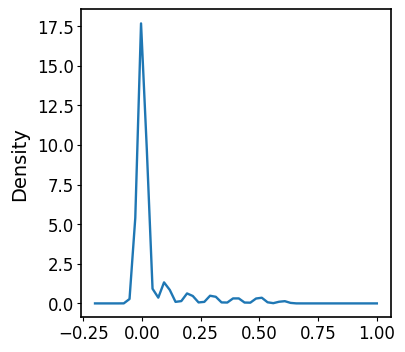

In [ ]:
print(query_data.obs["celltype_uncertainty"].mean(), np.quantile(query_data.obs["celltype_uncertainty"], 0.75))
query_data.obs["celltype_uncertainty"].plot(kind='density', ind=np.linspace(-0.2, 1))

In [ ]:
def get_comparison_df(uncertainty_threshold = None):
    # build comparison_df
    comparison_df = pd.DataFrame(index=query_data.obs_names, columns=["pred", "ground_truth", "pred_uncertainty"])
    comparison_df["pred"] = query_data.obs["celltype_pred"]
    comparison_df["pred_uncertainty"] = query_data.obs["celltype_uncertainty"]
    comparison_df["ground_truth"] = query_data.obs["Manually_curated_celltype"].fillna("Unknown")

    # we dont care about cases where we dont know the ground truth (in fact we could have skipped prediction for these altogether)
    n_before = len(comparison_df)
    comparison_df = comparison_df[comparison_df["ground_truth"] != "Unknown"]
    n_filtered = n_before-len(comparison_df)
    pct_filtered = 100*n_filtered/n_before
    print(f"filtered out {n_filtered} barcodes ({pct_filtered:.2f}%) with unknown ground truth")

    if uncertainty_threshold is not None:
        # filter out uncertainty > threshold
        n_before = len(comparison_df)
        comparison_df = comparison_df[comparison_df["pred_uncertainty"] <= uncertainty_threshold]
        n_filtered = n_before-len(comparison_df)
        pct_filtered = 100*n_filtered/n_before
        print(f"filtered out {n_filtered} barcodes ({pct_filtered:.2f}%) with pred uncertainty < {uncertainty_threshold}")

    return comparison_df

In [ ]:
comparison_df = get_comparison_df(uncertainty_threshold=0.2)

filtered out 0 barcodes (0.00%) with unknown ground truth
filtered out 740 barcodes (8.36%) with pred uncertainty < 0.2


## 6️⃣ Plot
Let's plot heatmap

In [3]:
temp_fig_dir = "/home/cane/Documents/yoseflab/can/scvi-hub/query_ref/"

In [ ]:
comparison_df["pred"].value_counts()

T cell lineage             5472
Innate lymphoid cell NK    2634
Multiciliated lineage         3
Unknown                       2
Mast cells                    1
Name: pred, dtype: int64

In [ ]:
comparison_df.groupby("pred")["pred_uncertainty"].mean()

pred
Innate lymphoid cell NK    0.025322
Mast cells                 0.099994
Multiciliated lineage      0.000000
T cell lineage             0.004240
Unknown                    0.150005
Name: pred_uncertainty, dtype: float64

In [ ]:
comparison_df = comparison_df.loc[comparison_df["pred"].isin(["T cell lineage", "Innate lymphoid cell NK"])]
comparison_df["pred"].value_counts()

T cell lineage             5472
Innate lymphoid cell NK    2634
Name: pred, dtype: int64

Some notes on the new HLCA annotations (https://zenodo.org/record/6337966/ vs https://zenodo.org/record/7599104):
- All new 60 cells have None for ann_level_3 annotations.
- No cells was predicted as "Smooth muscle FAM83D+" (even before thresholding on prediction uncertainty)
- In prev ann_level_3, not in new: 'Fibromyocytes'
- In new ann_level_3, not in prev: 'Smooth muscle FAM83D+'
- Only 565 cells differ between prev and new ann_level_3 annotations and their distribution is (prev, new):  
Fibromyocytes,Smooth muscle FAM83D+   -> 335  
Secretory,AT2                       ->   230

In [ ]:
# https://docs.scvi-tools.org/en/stable/tutorials/notebooks/cellassign_tutorial.html#Model-reproducibility
confusion_matrix = pd.crosstab(
    comparison_df["pred"],
    comparison_df["ground_truth"], 
    rownames=["Predicted label"],
    colnames=["True label"],
)
confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)
confusion_matrix *= 100

<Axes: xlabel='True label', ylabel='Predicted label'>

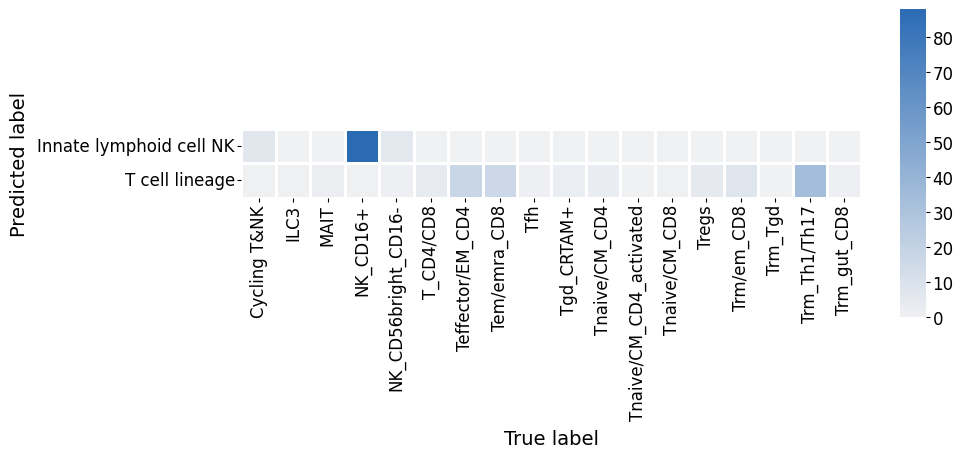

In [ ]:
from matplotlib.colors import LogNorm, Normalize

fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(
    confusion_matrix,
    # cmap=sns.diverging_palette(245, 320, s=60, as_cmap=True),
    cmap=sns.color_palette("light:#2b6bb4", as_cmap=True),
    ax=ax,
    square=True,
    fmt=".2f",
    cbar_kws=dict(shrink=0.4, aspect=12),
    linecolor='white',
    linewidths=1, 
    # annot=True,
    # norm=LogNorm()
)

## 7️⃣ Visualize embeddings in the joint latent space

Combine embeddings

In [ ]:
query_data.obs["dataset"] = "pan_immune"
query_data

AnnData object with n_obs × n_vars = 8852 × 2000
    obs: 'donor_id', 'Predicted_labels_CellTypist', 'Majority_voting_CellTypist', 'Manually_curated_celltype', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'suspension_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'dataset', 'scanvi_label', '_scvi_batch', '_scvi_labels', 'celltype_pred', 'celltype_uncertainty'
    var: 'gene_symbols', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype'
    uns: '_scvi_manager_uuid', '_scvi_uuid'
    obsm: 'X_umap', 'X_scanvi_emb'

In [ ]:
adata

AnnData object with n_obs × n_vars = 2282447 × 56295
    obs: 'suspension_type', 'donor_id', 'is_primary_data', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'tissue_ontology_term_id', 'organism_ontology_term_id', 'sex_ontology_term_id', "3'_or_5'", 'BMI', 'age_or_mean_of_age_range', 'age_range', 'anatomical_region_ccf_score', 'ann_coarse_for_GWAS_and_modeling', 'ann_finest_level', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'cause_of_death', 'core_or_extension', 'dataset', 'fresh_or_frozen', 'log10_total_counts', 'lung_condition', 'mixed_ancestry', 'original_ann_level_1', 'original_ann_level_2', 'original_ann_level_3', 'original_ann_level_4', 'original_ann_level_5', 'original_ann_nonharmonized', 'reannotation_type', 'sample', 'scanvi_label', 'sequencing_platform', 'smoking_status', 'study', 'subject_type', 'tissue_coarse_unharmonized', 

In [ ]:
combined_data = adata.concatenate(query_data)

/tmp/ipykernel_414824/303776516.py:1: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  combined_data = adata.concatenate(query_data)
/home/cane/miniconda3/envs/resolvi_new/lib/python3.10/site-packages/anndata/_core/merge.py:1337: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


## 8️⃣ Visualize embeddings and label infusion

In [ ]:
combined_data.var['feature_is_filtered-1'] = combined_data.var['feature_is_filtered-1'].astype("category")

In [ ]:
combined_data.write_h5ad(f"{local_dir}/combined_data_extended.h5ad")

In [ ]:
sc.pp.neighbors(combined_data, use_rep="X_scanvi_emb", method='rapids')
sc.tl.umap(combined_data, min_dist=0.3, method='rapids')
combined_data.write_h5ad(f"{local_dir}/combined_data_extended.h5ad")

#combined_emb_umap = anndata.read_h5ad(f"{local_dir}/combined_emb_umap.h5ad")

/home/cane/miniconda3/envs/resolvi_new/lib/python3.10/site-packages/cudf/utils/_numba.py:110: UserWarning: Using CUDA toolkit version (12, 1) with CUDA driver version (12, 0) requires minor version compatibility, which is not yet supported for CUDA driver versions 12.0 and above. It is likely that many cuDF operations will not work in this state. Please install CUDA toolkit version (12, 0) to continue using cuDF.
  warnings.warn(


In [3]:
import scanpy as sc
import anndata
combined_data = sc.read_h5ad(f"{local_dir}/combined_data_extended.h5ad")

/home/cane/miniconda3/envs/hub_paper/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/cane/miniconda3/envs/hub_paper/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


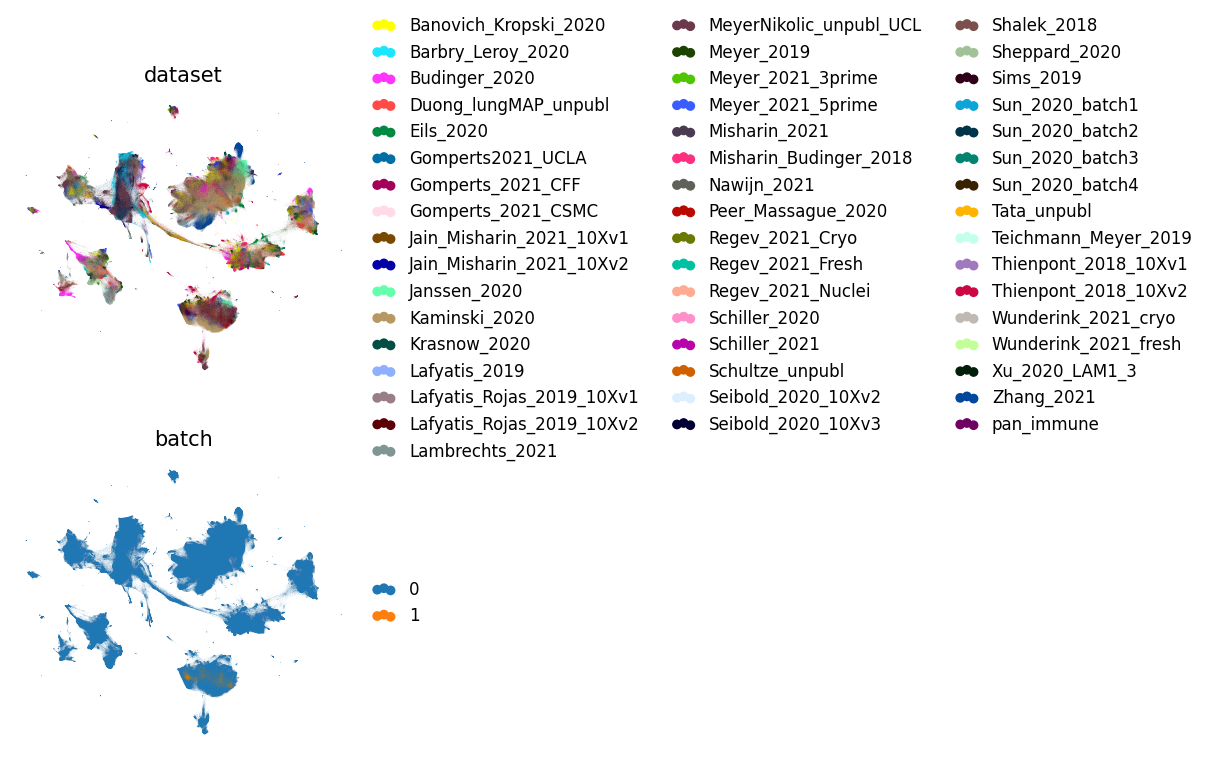

In [9]:
sc.pl.umap(
    combined_data,
    color=["dataset", "batch"],
    ncols=1,
    frameon=False,
)

In [4]:
idx1 = combined_data.obs["batch"] == "1"
idx2 = combined_data.obs["dataset"] == "pan_immune"
assert idx1.equals(idx2)

In [5]:
sc.set_figure_params(vector_friendly=True, dpi_save=300)

In [6]:
df = combined_data.obs
default_size = 120000 / len(df) # default scanpy
df["umap_size"] = default_size * 10
df.loc[df["batch"] == "1", "umap_size"] = default_size * 10 # if you want to make the query dataset points bigger
combined_data.obs = df

In [7]:
combined_data.var_names = combined_data.var['feature_name-0']

/home/cane/miniconda3/envs/hub_paper/lib/python3.10/site-packages/anndata/_core/anndata.py:947: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['A1BG', 'A2M', 'ABCA1', 'ABCA3', 'ABCA6']

    Inferred to be: categorical

  names = self._prep_dim_index(names, "var")


In [8]:
pd.options.display.max_rows = 1000

/home/cane/miniconda3/envs/hub_paper/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/home/cane/miniconda3/envs/hub_paper/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


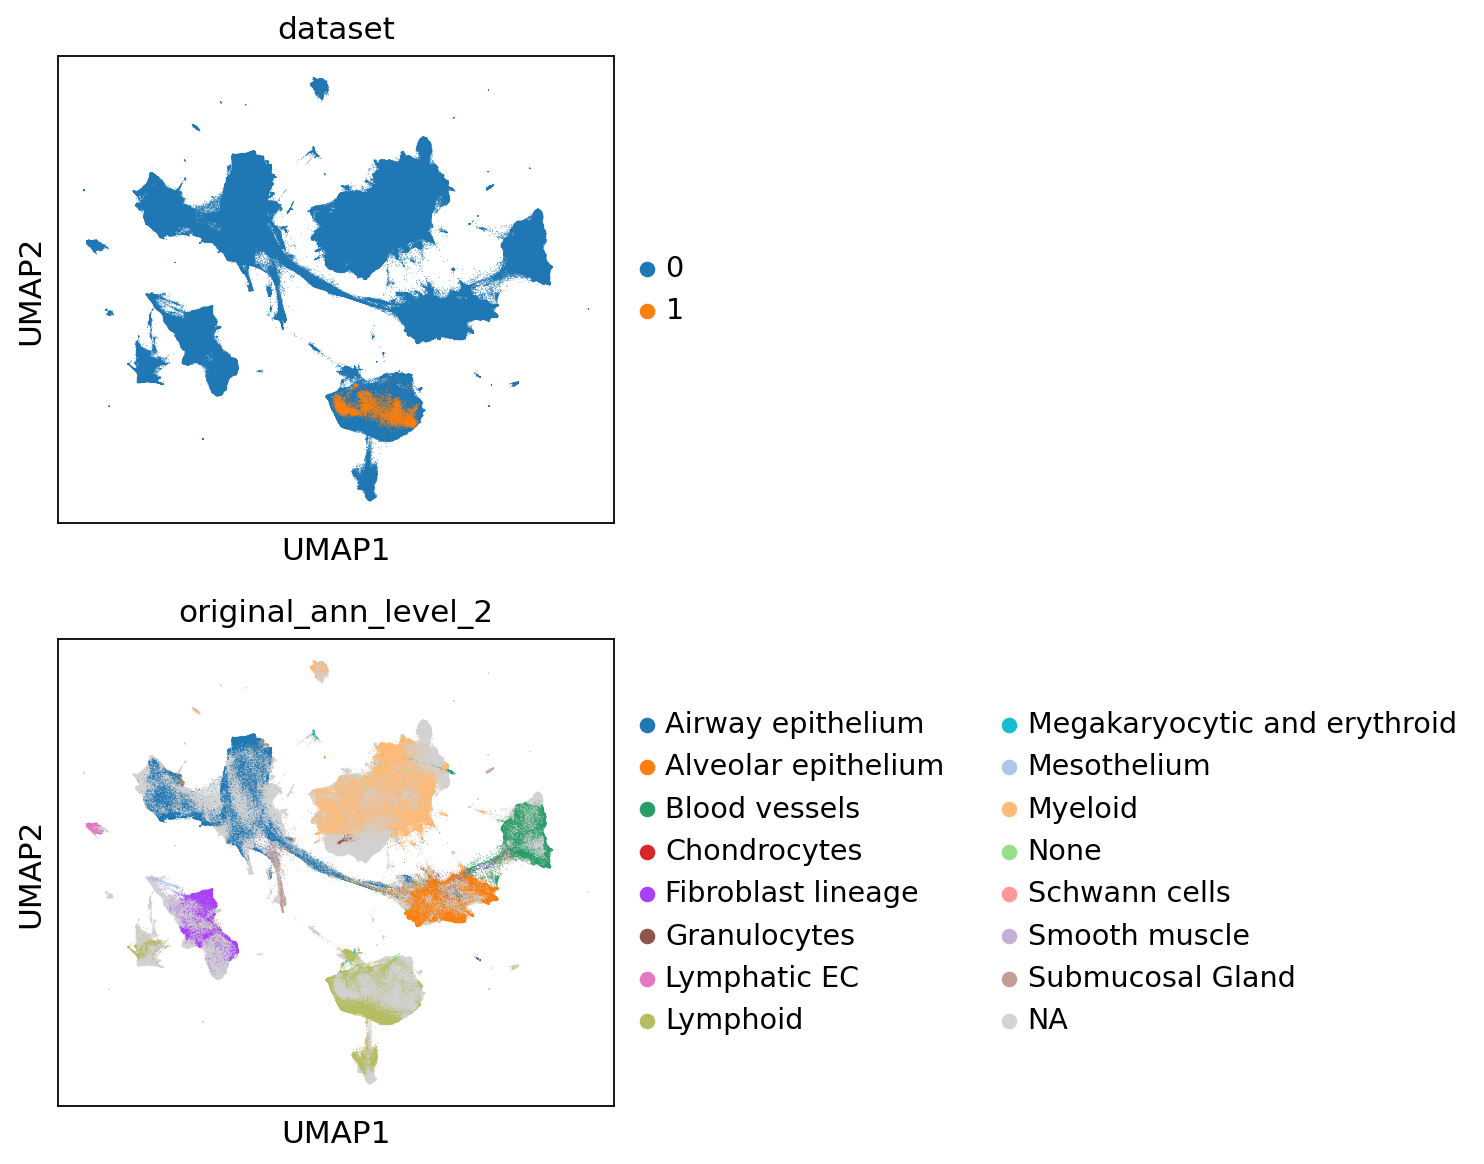

In [9]:
sc.pl.umap(
    combined_data,
    color=["batch", "original_ann_level_2"],
    ncols=1,
    frameon=True,
    save="combined_umap_batch_panimmune.svg",
    size=combined_data.obs["umap_size"],
    title="dataset",
    sort_order=False,
)

In [11]:
pd.options.display.max_rows = 1000

/home/cane/miniconda3/envs/hub_paper/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


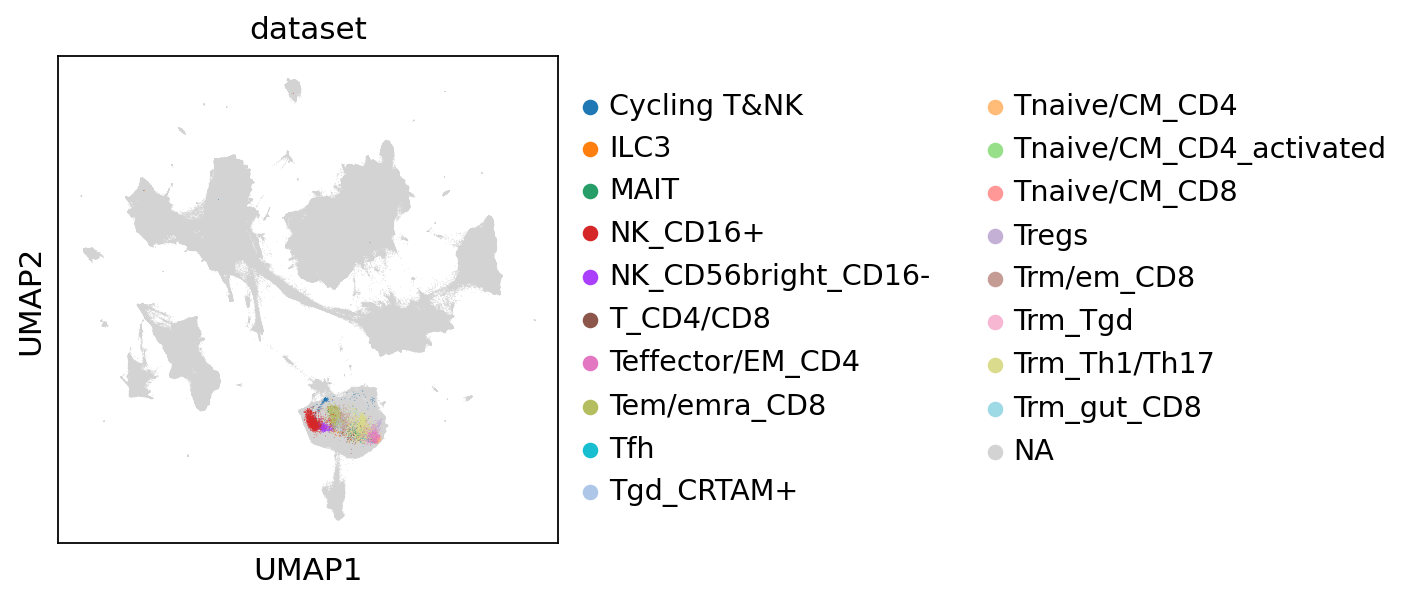

In [12]:
sc.pl.umap(
    combined_data,
    color=["Manually_curated_celltype"],
    ncols=1,
    frameon=True,
    save="combined_umap_celltype_panimmune.svg",
    size=combined_data.obs["umap_size"],
    title="dataset"
)

In [13]:
query_data = combined_data[combined_data.obs['batch'] == '1'].copy()
query = query_data.obsm['X_scanvi_emb']
query_nn_index = pynndescent.NNDescent(query)
query_nn_index.prepare()

/home/cane/miniconda3/envs/hub_paper/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [12]:
combined_neighbors, combined_distances = query_nn_index.query(combined_data.obsm['X_scanvi_emb'])

NameError: name 'query_nn_index' is not defined

In [49]:
def distances_to_affinities(distances):
    # convert distances to affinities
    stds = np.std(distances, axis=1)
    stds = (2.0 / stds) ** 2
    stds = stds.reshape(-1, 1)
    distances_tilda = np.exp(-np.true_divide(distances, stds))
    weights = distances_tilda / np.sum(
        distances_tilda, axis=1, keepdims=True
    )
    return weights

# import numba
# @numba.njit
def weighted_prediction(weights, ref_cats):
    """Get highest weight category."""
    N = len(weights)
    predictions = np.zeros((N,), dtype=ref_cats.dtype)
    uncertainty = np.zeros((N,))
    for i in range(N):
        obs_weights = weights[i]
        obs_cats = ref_cats[i]
        best_prob = 0
        for c in np.unique(obs_cats):
            cand_prob = np.sum(obs_weights[obs_cats == c])
            if cand_prob > best_prob:
                best_prob = cand_prob
                predictions[i] = c
                uncertainty[i] = max(1 - best_prob, 0)

    return predictions, uncertainty

weights = distances_to_affinities(combined_distances)

In [50]:
query_data = combined_data[combined_data.obs['batch'] == '1'].copy()

/home/cane/miniconda3/envs/resolvi_new/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [51]:
label_key = "Manually_curated_celltype"
query_cats = query_data.obs[label_key].cat.codes.to_numpy()[combined_neighbors]
p, u = weighted_prediction(weights, query_cats)
p = np.asarray(query_data.obs[label_key].cat.categories)[p]
combined_data.obs["celltype_pred"], combined_data.obs["celltype_uncertainty"] = p, u

0.37796249844772095 0.5998799502849579


<Axes: ylabel='Density'>

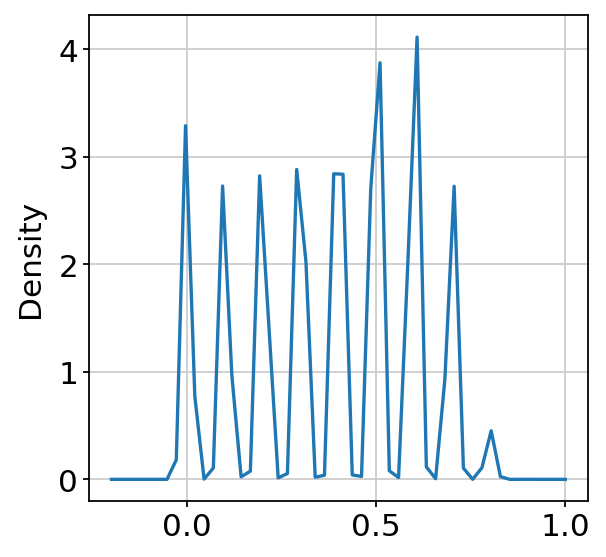

In [52]:
print(combined_data.obs["celltype_uncertainty"].mean(), np.quantile(combined_data.obs["celltype_uncertainty"], 0.75))
combined_data.obs["celltype_uncertainty"].plot(kind='density', ind=np.linspace(-0.2, 1))

## 9️⃣ Downstream analysis on Tcells

In [8]:
import scanpy as sc
import anndata
combined_data = sc.read_h5ad(f"{local_dir}/combined_data_extended_annotated.h5ad")

/home/cane/miniconda3/envs/hub_paper/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [9]:
ref_tcell = combined_data[np.logical_or(combined_data.obs['ann_level_3'].isin(['T cell lineage', 'Innate lymphoid cell NK']), combined_data.obs['batch']=='1')]

In [10]:
ref_tcell.obs['celltype_pred'].value_counts()

Trm_Th1/Th17               95375
NK_CD16+                   53623
Tem/emra_CD8               53152
Teffector/EM_CD4           37874
Trm/em_CD8                 20614
Tregs                      10980
T_CD4/CD8                   6750
Cycling T&NK                6581
NK_CD56bright_CD16-         4934
MAIT                        4052
Tgd_CRTAM+                  3559
Tnaive/CM_CD4               1791
Trm_gut_CD8                 1181
Tnaive/CM_CD8                835
Tfh                          631
Trm_Tgd                      476
ILC3                         472
Tnaive/CM_CD4_activated       16
Name: celltype_pred, dtype: int64

In [11]:
combined_data.obs['celltype_certainty'] = 1 - combined_data.obs['celltype_uncertainty']

In [12]:
df = combined_data.obs
default_size = 12000 / len(df) # default scanpy
df["umap_size"] = default_size * 10
df.loc[df["batch"] == "1", "umap_size"] = default_size * 30 # if you want to make the query dataset points bigger
combined_data.obs = df

/home/cane/miniconda3/envs/hub_paper/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


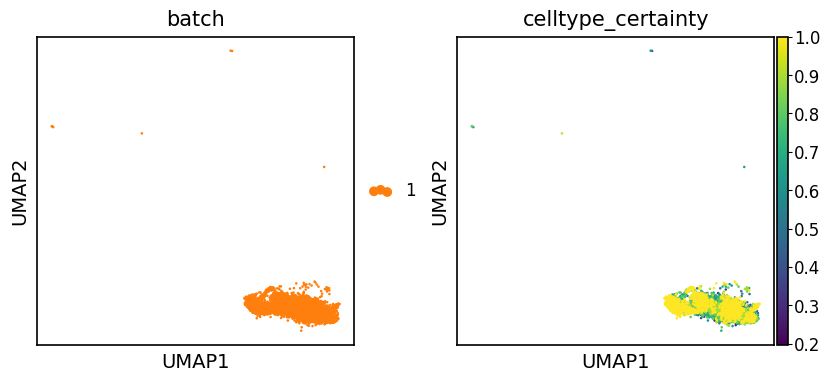

In [13]:
sc.pl.umap(
    combined_data[combined_data.obs['batch'] == '1'],
    color=["batch", "celltype_certainty"],
    #title="dataset"
)

In [14]:
sc.pl.umap(
    combined_data,
    color=["batch", "CD3D"],
    ncols=1,
    sort_order=True,
    frameon=True,
    save="combined_umap_certainty_panimmune.svg",
    size=combined_data.obs["umap_size"],
    #title="dataset"
)

/home/cane/miniconda3/envs/hub_paper/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


In [ ]:
pd.options.display.max_rows = 1000

In [ ]:
query_combined = combined_data[combined_data.obs['batch'] == '1'].copy()
ref_combined = combined_data[np.logical_and(combined_data.obs['ann_level_3'].isin(['T cell lineage', 'Innate lymphoid cell NK']), combined_data.obs['batch']=='0')]

In [ ]:
def get_comparison_df(adata, uncertainty_threshold = None, ground_truth="Manually_curated_celltype"):
    # build comparison_df
    comparison_df = pd.DataFrame(index=adata.obs_names, columns=["pred", "ground_truth", "pred_uncertainty"])
    comparison_df["pred"] = adata.obs["celltype_pred"]
    comparison_df["pred_uncertainty"] = adata.obs["celltype_uncertainty"]
   #adata.obs[ground_truth].cat.add_categories("Unknown", inplace=True)
    comparison_df["ground_truth"] = adata.obs[ground_truth].fillna("Unknown")

    # we dont care about cases where we dont know the ground truth (in fact we could have skipped prediction for these altogether)
    n_before = len(comparison_df)
    comparison_df = comparison_df[comparison_df["ground_truth"] != "Unknown"]
    n_filtered = n_before-len(comparison_df)
    pct_filtered = 100*n_filtered/n_before

    if uncertainty_threshold is not None:
        # filter out uncertainty > threshold
        n_before = len(comparison_df)
        comparison_df = comparison_df[comparison_df["pred_uncertainty"] <= uncertainty_threshold]
        n_filtered = n_before-len(comparison_df)
        pct_filtered = 100*n_filtered/n_before
        print(f"filtered out {n_filtered} barcodes ({pct_filtered:.2f}%) with pred uncertainty < {uncertainty_threshold}")
    return comparison_df

In [ ]:
comparison_df = get_comparison_df(query_combined, uncertainty_threshold=0.2)

filtered out 2547 barcodes (28.77%) with pred uncertainty < 0.2


In [ ]:
ref_combined.obs

suspension_type  \
scrBT1428_CCACGGATCGCATGGC_lambrechts-0                       cell   
39752_laughney-0                                              cell   
AACCATGAGGGAAACA-WSSS8015045-0_meyer_unpubl-0                 cell   
051I_CGTTAGACAGTTTACG_adams-0                                 cell   
TACTCGCGTGTGGTTT-1-HCATisStab7747197-0                        cell   
...                                                            ...   
MUC28291_GCCAACGTCAGCGTCG-1_schiller_discovair-0              cell   
3782_laughney-0                                               cell   
TGCTCGTAGACGAGCT_1-PX1-sub_mould-0                            cell   
12-P485759-S008-R01-AAGCATCAGTCTAGCT_delorey_nu...         nucleus   
ACGGGCTCATTAGGCT-1-WTDAtest7732265-0_meyer_unpu...            cell   

                                                                                             donor_id  \
scrBT1428_CCACGGATCGCATGGC_lambrechts-0             homosapiens_None_2023_None_sikkemalisa_002_d10...   
39752_laughney-0                                    homosapiens_None_2023_None_sikkemalisa_002_d10...   
AACCATGAGGGAAACA-WSSS8015045-0_meyer_unpubl-0       homosapiens_None_2023_None_sikkemalisa_002_d10...   
051I_CGTTAGACAGTTTACG_adams-0                       homosapiens_None_2023_None_sikkemalisa_002_d10...   
TACTCGCGTGTGGTTT-1-HCATisStab7747197-0              homosapiens_None_2023_None_sikkemalisa_002_d10...   
...                                                                                               ...   
MUC28291_GCCAACGTCAGCGTCG-1_schiller_discovair-0    homosapiens_None_2023_None_sikkemalisa_002_d10...   
3782_laughney-0                                     homosapiens_None_2023_None_sikkemalisa_002_d10...   
TGCTCGTAGACGAGCT_1-PX1-sub_mould-0                  homosapiens_None_2023_None_sikkemalisa_002_d10...   
12-P485759-S008-R01-AAGCATCAGTCTAGCT_delorey_nu...  homosapiens_None_2023_None_sikkemalisa_002_d10...   
ACGGGCTCATTAGGCT-1-WTDAtest7732265-0_meyer_unpu...  homosapiens_None_2023_None_sikkemalisa_002_d10...   

                                                    is_primary_data  \
scrBT1428_CCACGGATCGCATGGC_lambrechts-0                        True   
39752_laughney-0                                               True   
AACCATGAGGGAAACA-WSSS8015045-0_meyer_unpubl-0                 False   
051I_CGTTAGACAGTTTACG_adams-0                                 False   
TACTCGCGTGTGGTTT-1-HCATisStab7747197-0                        False   
...                                                             ...   
MUC28291_GCCAACGTCAGCGTCG-1_schiller_discovair-0               True   
3782_laughney-0                                                True   
TGCTCGTAGACGAGCT_1-PX1-sub_mould-0                             True   
12-P485759-S008-R01-AAGCATCAGTCTAGCT_delorey_nu...            False   
ACGGGCTCATTAGGCT-1-WTDAtest7732265-0_meyer_unpu...            False   

                                                   assay_ontology_term_id  \
scrBT1428_CCACGGATCGCATGGC_lambrechts-0                       EFO:0030003   
39752_laughney-0                                              EFO:0009899   
AACCATGAGGGAAACA-WSSS8015045-0_meyer_unpubl-0                 EFO:0011025   
051I_CGTTAGACAGTTTACG_adams-0                                 EFO:0009899   
TACTCGCGTGTGGTTT-1-HCATisStab7747197-0                        EFO:0009899   
...                                                                   ...   
MUC28291_GCCAACGTCAGCGTCG-1_schiller_discovair-0              EFO:0009922   
3782_laughney-0                                               EFO:0009899   
TGCTCGTAGACGAGCT_1-PX1-sub_mould-0                            EFO:0009922   
12-P485759-S008-R01-AAGCATCAGTCTAGCT_delorey_nu...            EFO:0009922   
ACGGGCTCATTAGGCT-1-WTDAtest7732265-0_meyer_unpu...            EFO:0009899   

                                                   cell_type_ontology_term_id  \
scrBT1428_CCACGGATCGCATGGC_lambrechts-0                            CL:0000625   
39752_lau

In [ ]:
comparison_df_ref = get_comparison_df(ref_combined, uncertainty_threshold=1.0, ground_truth="ann_finest_level")

filtered out 0 barcodes (0.00%) with pred uncertainty < 1.0


In [ ]:
comparison_df_ref.groupby("ground_truth")["pred_uncertainty"].mean()

ground_truth
CD4 T cells              0.298908
CD8 T cells              0.316484
NK cells                 0.033547
T cells proliferating    0.042380
Unknown                       NaN
Name: pred_uncertainty, dtype: float64

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def _prediction_eval(
    pred,
    labels,
    name,
    x_label="",
    y_label="",
    save_fig=None,
):
    """Generate confusion matrix."""
    types, _ = np.unique(np.concatenate([labels, pred]), return_inverse=True)
    mtx = confusion_matrix(labels, pred, normalize="true")
    df = pd.DataFrame(mtx, columns=types, index=types)
    df = df.loc[np.unique(labels), np.unique(pred)]
    df = df.rename_axis(x_label, axis="columns")
    df = df.rename_axis(y_label)
    df = df[df.idxmax(axis=1).unique()]
    print(pred.value_counts().index[pred.value_counts()>1], labels.value_counts().index[labels.value_counts()>1])
    df = df[pred.value_counts().index[pred.value_counts()>1]]
    df = df.loc[labels.value_counts().index[labels.value_counts()>1]]
    positions = [df.columns.get_loc(index) for index in df.idxmax(axis=1)]
    df = df.loc[df.index[np.argsort(positions)]]
    fig, ax = plt.subplots(figsize=[15, 15])
    sns.heatmap(df.T, linewidths=0.005, cmap="OrRd", square=True)
    plt.tight_layout()
    plt.title(name)
    plt.xlabel('PopV prediction')
    plt.ylabel('Original Annotation')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

    if save_fig:
        plt.savefig(save_fig)
    plt.show()
    
    return df

CategoricalIndex(['NK_CD16+', 'Trm_Th1/Th17', 'Tem/emra_CD8',
                  'Teffector/EM_CD4', 'NK_CD56bright_CD16-', 'Cycling T&NK',
                  'Trm/em_CD8', 'Tregs', 'Tgd_CRTAM+', 'MAIT', 'Tnaive/CM_CD4',
                  'T_CD4/CD8', 'Tnaive/CM_CD8', 'ILC3'],
                 categories=['Cycling T&NK', 'ILC3', 'MAIT', 'NK_CD16+', ..., 'Trm/em_CD8', 'Trm_Tgd', 'Trm_Th1/Th17', 'Trm_gut_CD8'], ordered=False, dtype='category') CategoricalIndex(['NK_CD16+', 'Trm_Th1/Th17', 'Tem/emra_CD8',
                  'Teffector/EM_CD4', 'NK_CD56bright_CD16-', 'Cycling T&NK',
                  'Trm/em_CD8', 'Tregs', 'Tgd_CRTAM+', 'T_CD4/CD8', 'MAIT',
                  'Tnaive/CM_CD4', 'ILC3', 'Tnaive/CM_CD8', 'Tfh', 'Trm_Tgd',
                  'Trm_gut_CD8'],
                 categories=['Cycling T&NK', 'ILC3', 'MAIT', 'NK_CD16+', ..., 'Trm/em_CD8', 'Trm_Tgd', 'Trm_Th1/Th17', 'Trm_gut_CD8'], ordered=False, dtype='category')


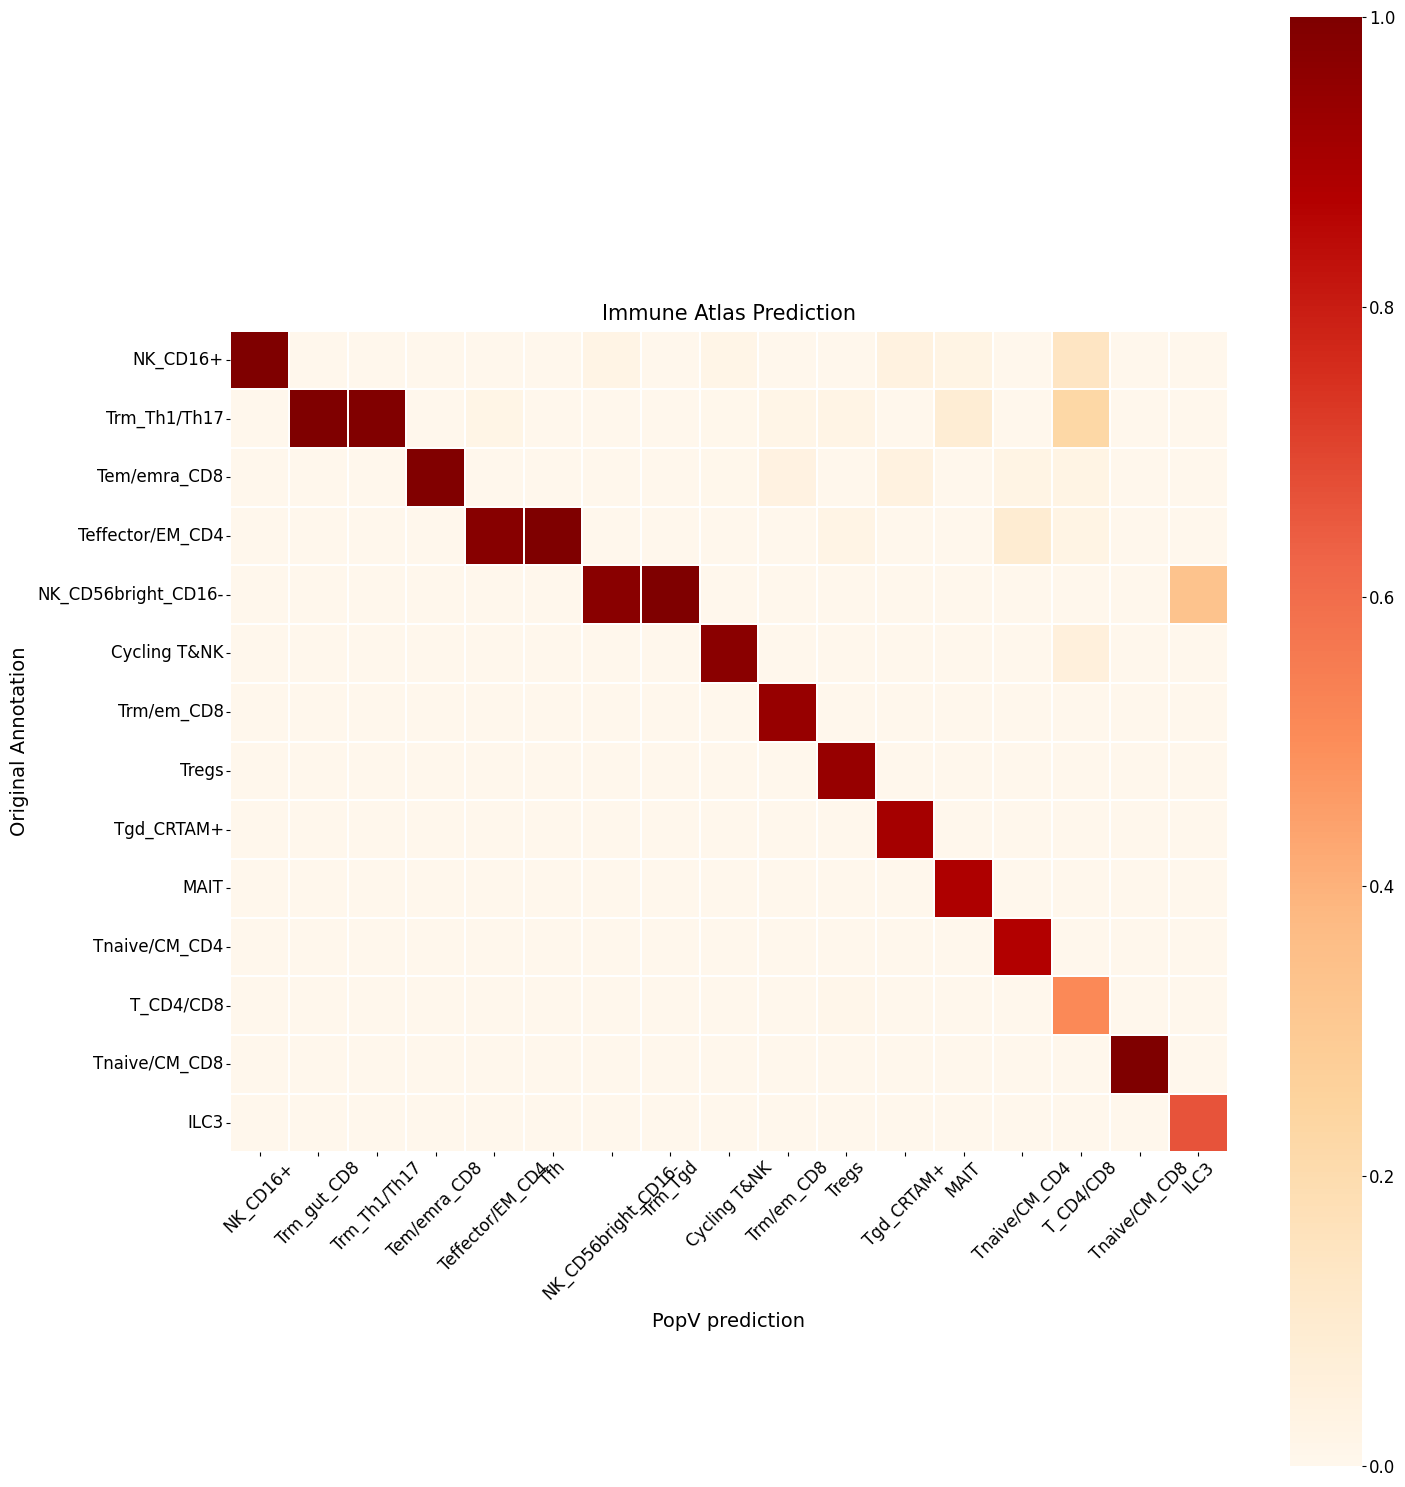

In [ ]:
_ = _prediction_eval(
    pred=comparison_df["pred"],
    labels=comparison_df["ground_truth"],
    name='Immune Atlas Prediction',
    x_label=["Predicted label"],
    y_label=["True label"],
    save_fig=f"immune_atlas_celltype_prediction.pdf",
)

CategoricalIndex(['CD8 T cells', 'CD4 T cells', 'NK cells',
                  'T cells proliferating'],
                 categories=['CD4 T cells', 'CD8 T cells', 'NK cells', 'T cells proliferating', 'Unknown'], ordered=False, dtype='category') CategoricalIndex(['Trm_Th1/Th17', 'NK_CD16+', 'Tem/emra_CD8',
                  'Teffector/EM_CD4', 'Trm/em_CD8', 'Tregs', 'Cycling T&NK',
                  'NK_CD56bright_CD16-', 'T_CD4/CD8', 'Tgd_CRTAM+', 'MAIT',
                  'Tnaive/CM_CD4', 'Trm_gut_CD8', 'Tnaive/CM_CD8', 'Tfh',
                  'Trm_Tgd', 'ILC3', 'Tnaive/CM_CD4_activated'],
                 categories=['Cycling T&NK', 'ILC3', 'MAIT', 'NK_CD16+', ..., 'Trm/em_CD8', 'Trm_Tgd', 'Trm_Th1/Th17', 'Trm_gut_CD8'], ordered=False, dtype='category')


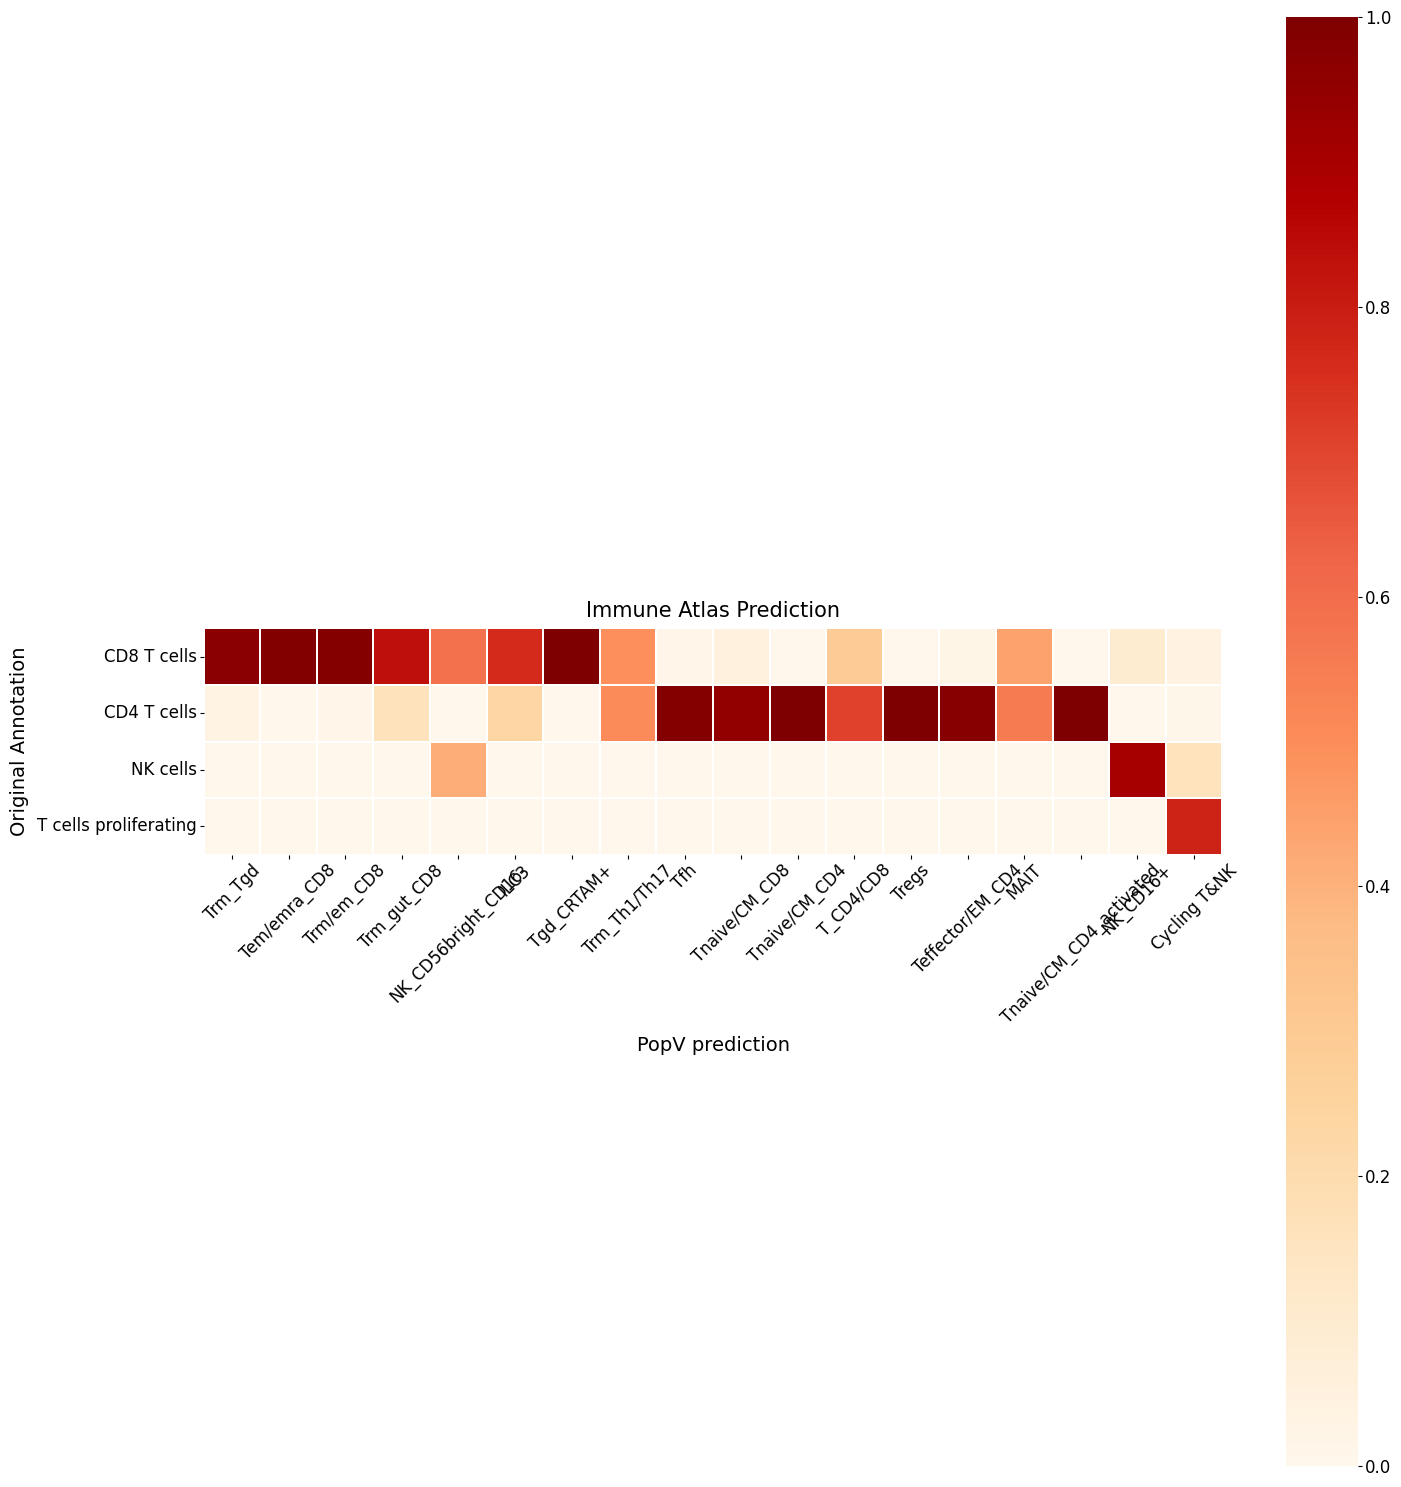

In [ ]:
dfc = _prediction_eval(
    pred=comparison_df_ref["ground_truth"],
    labels=comparison_df_ref["pred"],
    name='Immune Atlas Prediction',
    x_label=["Predicted label"],
    y_label=["True label"],
    save_fig=f"immune_atlas_celltype_prediction_ref.svg",
)

In [ ]:
combined_data.obs['ann_level_3'].value_counts()

Macrophages                     524452
Unknown                         280408
T cell lineage                  245605
Secretory                       181002
AT2                             157476
Basal                           144420
Fibroblasts                     129222
Multiciliated lineage           124124
Monocytes                       107416
B cell lineage                   71270
EC capillary                     70759
Innate lymphoid cell NK          48439
Dendritic cells                  41291
EC venous                        37838
AT1                              32306
Mast cells                       21323
EC arterial                      14724
Lymphatic EC mature              11680
Submucosal Secretory             11001
None                              3286
Rare                              3039
Myofibroblasts                    1926
SM activated stress response      1788
Lymphatic EC differentiating      1359
Smooth muscle FAM83D+              553
Lymphatic EC proliferatin

In [16]:
ref_tcell = combined_data[np.logical_or(combined_data.obs['ann_level_3'].isin(['T cell lineage', 'Innate lymphoid cell NK']), combined_data.obs['batch']=='1')]

In [17]:
ref_tcell.obs['celltype_pred'].value_counts()

Trm_Th1/Th17               93203
Tem/emra_CD8               52067
NK_CD16+                   50805
Teffector/EM_CD4           36769
Trm/em_CD8                 20284
Tregs                      10808
T_CD4/CD8                   6644
Cycling T&NK                6386
NK_CD56bright_CD16-         4479
MAIT                        3967
Tgd_CRTAM+                  3441
Tnaive/CM_CD4               1660
Trm_gut_CD8                 1160
Tnaive/CM_CD8                817
Tfh                          619
Trm_Tgd                      473
ILC3                         446
Tnaive/CM_CD4_activated       16
Name: celltype_pred, dtype: int64

2024-11-18 00:15:04.102585: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-18 00:15:04.102642: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-18 00:15:04.121997: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-18 00:15:04.841940: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/cane/miniconda3/envs/hub_paper/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/cane/miniconda3/en

/home/cane/miniconda3/envs/hub_paper/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


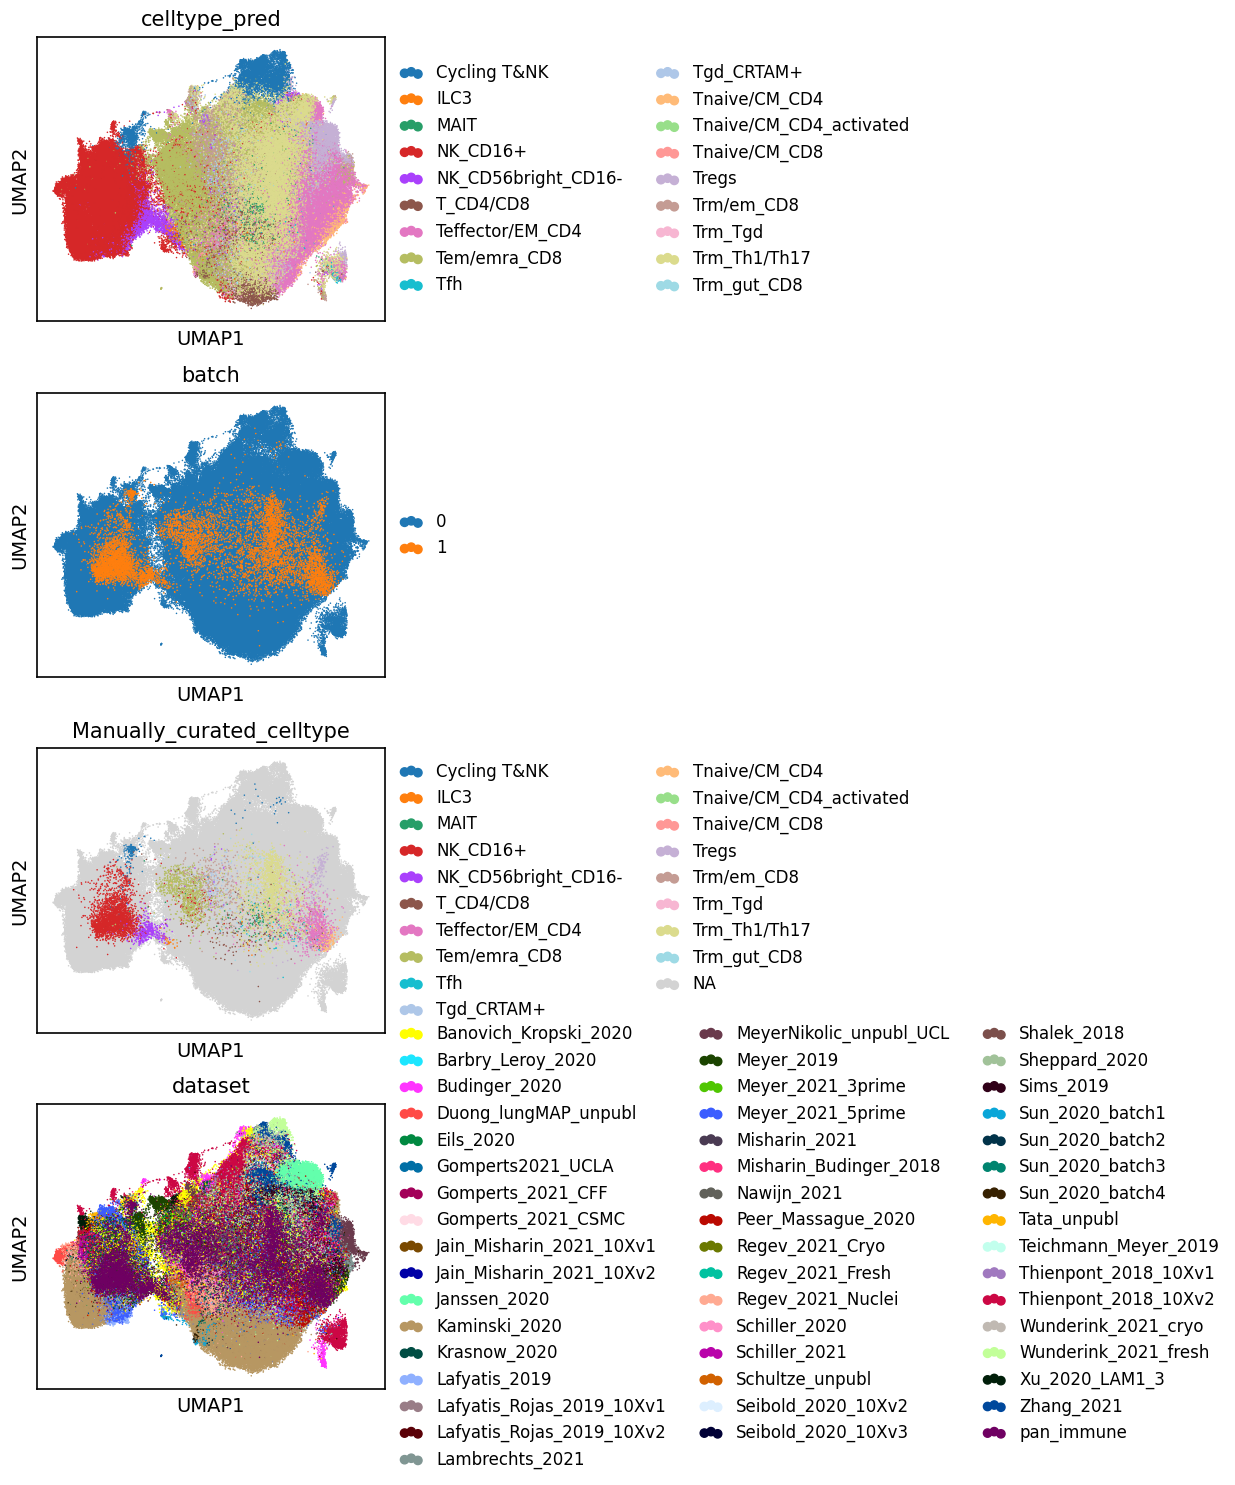

In [24]:
sc.pp.neighbors(ref_tcell, use_rep="X_scanvi_emb")
sc.tl.umap(ref_tcell)
sc.pl.umap(ref_tcell, color=['celltype_pred', 'batch', 'Manually_curated_celltype', 'dataset'], ncols=1, size=5, save='_predicted_tcells.pdf')

In [ ]:
ref_tcell2 = ref_tcell.copy()
ref_tcell.var.index = ref_tcell.var['feature_name-0']

In [26]:
query_cell = combined_data[combined_data.obs['batch'] == '0']

         Falling back to preprocessing with `sc.pp.pca` and default params.


/home/cane/miniconda3/envs/hub_paper/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/cane/miniconda3/envs/hub_paper/lib/python3.10/site-packages/scanpy/tools/_utils.py:46: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm['X_pca'] = X


/home/cane/miniconda3/envs/hub_paper/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


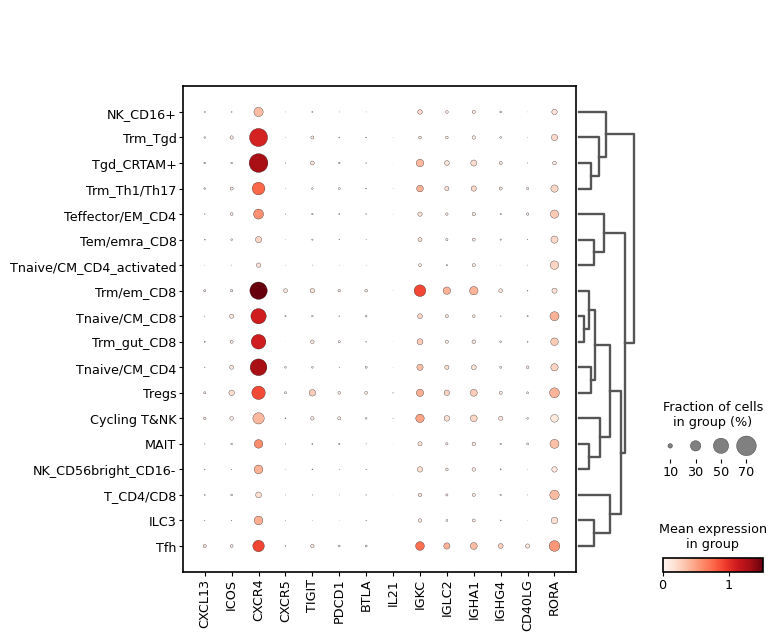

In [27]:
sc.pl.dotplot(query_cell, var_names=['CXCL13', 'ICOS', 'CXCR4', 'CXCR5', 'TIGIT', 'PDCD1', 'BTLA', 'IL21', 'IGKC', 'IGLC2', 'IGHA1', 'IGHG4', 'CD40LG', 'RORA'],
              groupby='celltype_pred', gene_symbols='feature_name-0', use_raw=False, dendrogram=True, save='tfh_genes_reference.svg')

/home/cane/miniconda3/envs/hub_paper/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


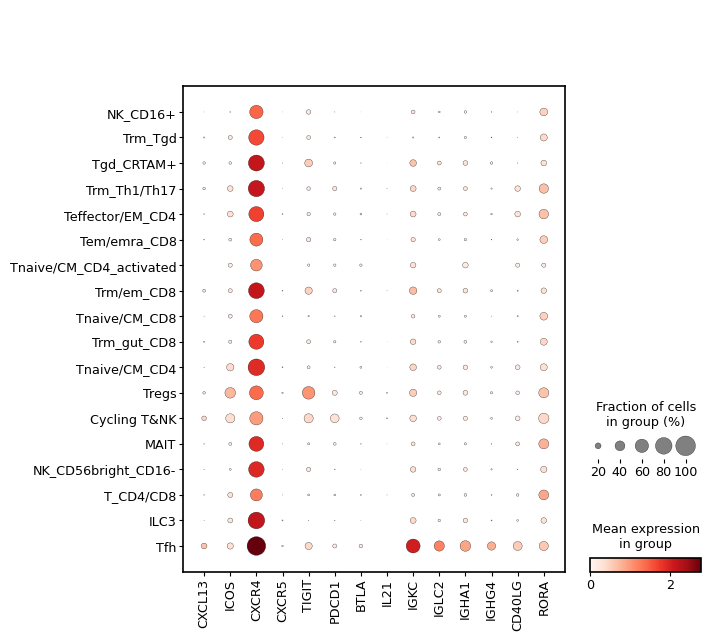

In [28]:
sc.pl.dotplot(ref_tcell, var_names=['CXCL13', 'ICOS', 'CXCR4', 'CXCR5', 'TIGIT', 'PDCD1', 'BTLA', 'IL21', 'IGKC', 'IGLC2', 'IGHA1', 'IGHG4', 'CD40LG', 'RORA'],
              groupby='celltype_pred', gene_symbols='feature_name-0', use_raw=False, dendrogram=False, save='tfh_genes_query.svg',
              categories_order=query_cell.uns['dendrogram_celltype_pred']['categories_ordered'])

         Falling back to preprocessing with `sc.pp.pca` and default params.


/home/cane/miniconda3/envs/hub_paper/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


/home/cane/miniconda3/envs/hub_paper/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


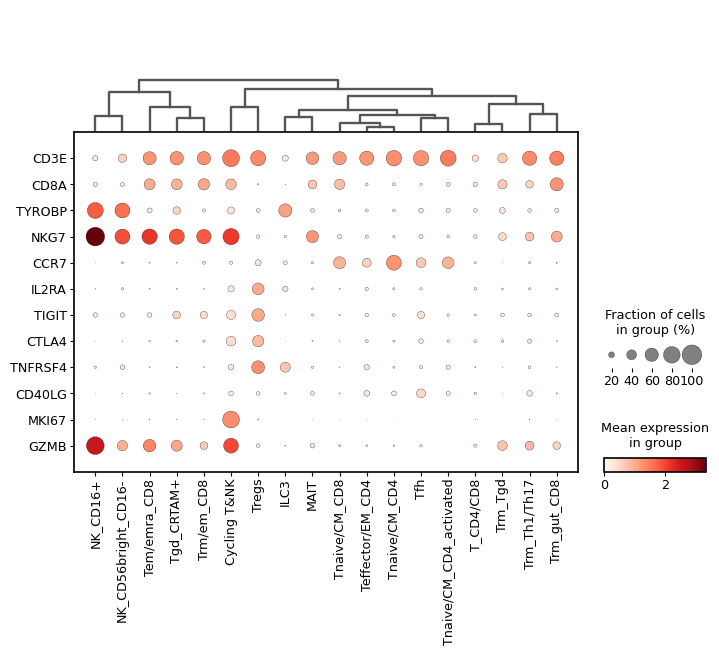

In [29]:
sc.pl.dotplot(ref_tcell, var_names=['CD3E', 'CD8A', 'TYROBP', 'NKG7', 'CCR7', 'IL2RA', 'TIGIT', 'CTLA4', 'TNFRSF4', 'CD40LG', 'MKI67', 'GZMB'],
              groupby='celltype_pred', gene_symbols='feature_name-0', save='_predicted_treg_markers.svg', use_raw=False, dendrogram=True, swap_axes=True)

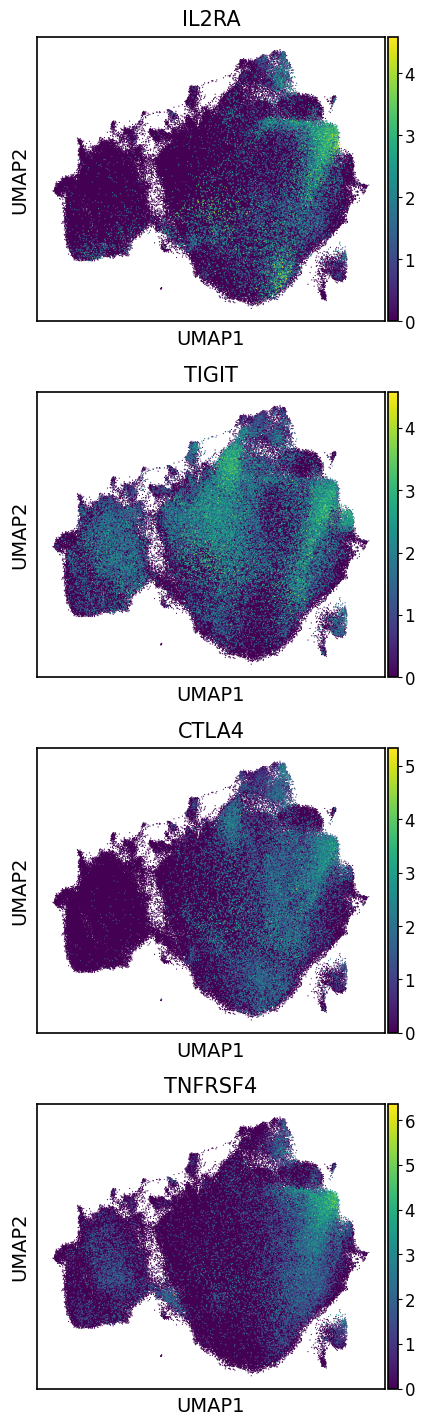

In [30]:
sc.pl.umap(ref_tcell, color=['IL2RA', 'TIGIT', 'CTLA4', 'TNFRSF4'], gene_symbols='feature_name-0', save='_predicted_treg_markers.pdf', size=3, ncols=1)

In [31]:
ref_tregs = combined_data[np.logical_and(combined_data.obs['ann_level_3'].isin(['T cell lineage', 'Innate lymphoid cell NK']), combined_data.obs['celltype_pred']=='Tem/emra_CD8')]

In [37]:
adata_full = sc.read_h5ad('/external_data/other/scvi-hub/scvi-hub/adata_extended2.h5ad')

In [39]:
adata_full.raw.X.data

array([1., 2., 1., ..., 1., 1., 1.], dtype=float32)

In [40]:
raw_tcell = adata_full[[i[:-2] for i in ref_tregs.obs_names]].copy()
raw_tcell.X = raw_tcell.raw.X

In [ ]:
raw_tcell.var_names = raw_tcell.var['feature_name'].astype(str)

In [ ]:
raw_tcell.obs['batch'] = raw_tcell.obs['donor_id'].astype(str) + raw_tcell.obs['dataset'].astype(str) + raw_tcell.obs['assay'].astype(str) + raw_tcell.obs['disease'].astype(str)

In [ ]:
import decoupler as dc

# Get pseudo-bulk profile
pdata = dc.get_pseudobulk(
    raw_tcell,
    sample_col='batch',
    groups_col=None,
    mode='sum',
    min_cells=10,
    min_counts=1000,
)
pdata

AnnData object with n_obs × n_vars = 307 × 37023
    obs: 'suspension_type', 'donor_id', 'is_primary_data', 'assay_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'organism_ontology_term_id', 'sex_ontology_term_id', "3'_or_5'", 'BMI', 'age_or_mean_of_age_range', 'age_range', 'ann_level_1', 'ann_level_2', 'cause_of_death', 'core_or_extension', 'dataset', 'fresh_or_frozen', 'mixed_ancestry', 'sequencing_platform', 'smoking_status', 'study', 'subject_type', 'tissue_dissociation_protocol', 'transf_ann_level_1_label', 'transf_ann_level_2_label', 'assay', 'disease', 'organism', 'sex', 'self_reported_ethnicity', 'development_stage', 'batch', 'psbulk_n_cells', 'psbulk_counts'
    var: 'feature_is_filtered', 'original_gene_symbols', 'feature_name', 'feature_reference', 'feature_biotype'
    layers: 'psbulk_props'

In [ ]:
pdata

AnnData object with n_obs × n_vars = 307 × 37023
    obs: 'suspension_type', 'donor_id', 'is_primary_data', 'assay_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'organism_ontology_term_id', 'sex_ontology_term_id', "3'_or_5'", 'BMI', 'age_or_mean_of_age_range', 'age_range', 'ann_level_1', 'ann_level_2', 'cause_of_death', 'core_or_extension', 'dataset', 'fresh_or_frozen', 'mixed_ancestry', 'sequencing_platform', 'smoking_status', 'study', 'subject_type', 'tissue_dissociation_protocol', 'transf_ann_level_1_label', 'transf_ann_level_2_label', 'assay', 'disease', 'organism', 'sex', 'self_reported_ethnicity', 'development_stage', 'batch', 'psbulk_n_cells', 'psbulk_counts'
    var: 'feature_is_filtered', 'original_gene_symbols', 'feature_name', 'feature_reference', 'feature_biotype'
    layers: 'psbulk_props'

/home/cane/miniconda3/envs/resolvi/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/cane/miniconda3/envs/resolvi/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/cane/miniconda3/envs/resolvi/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


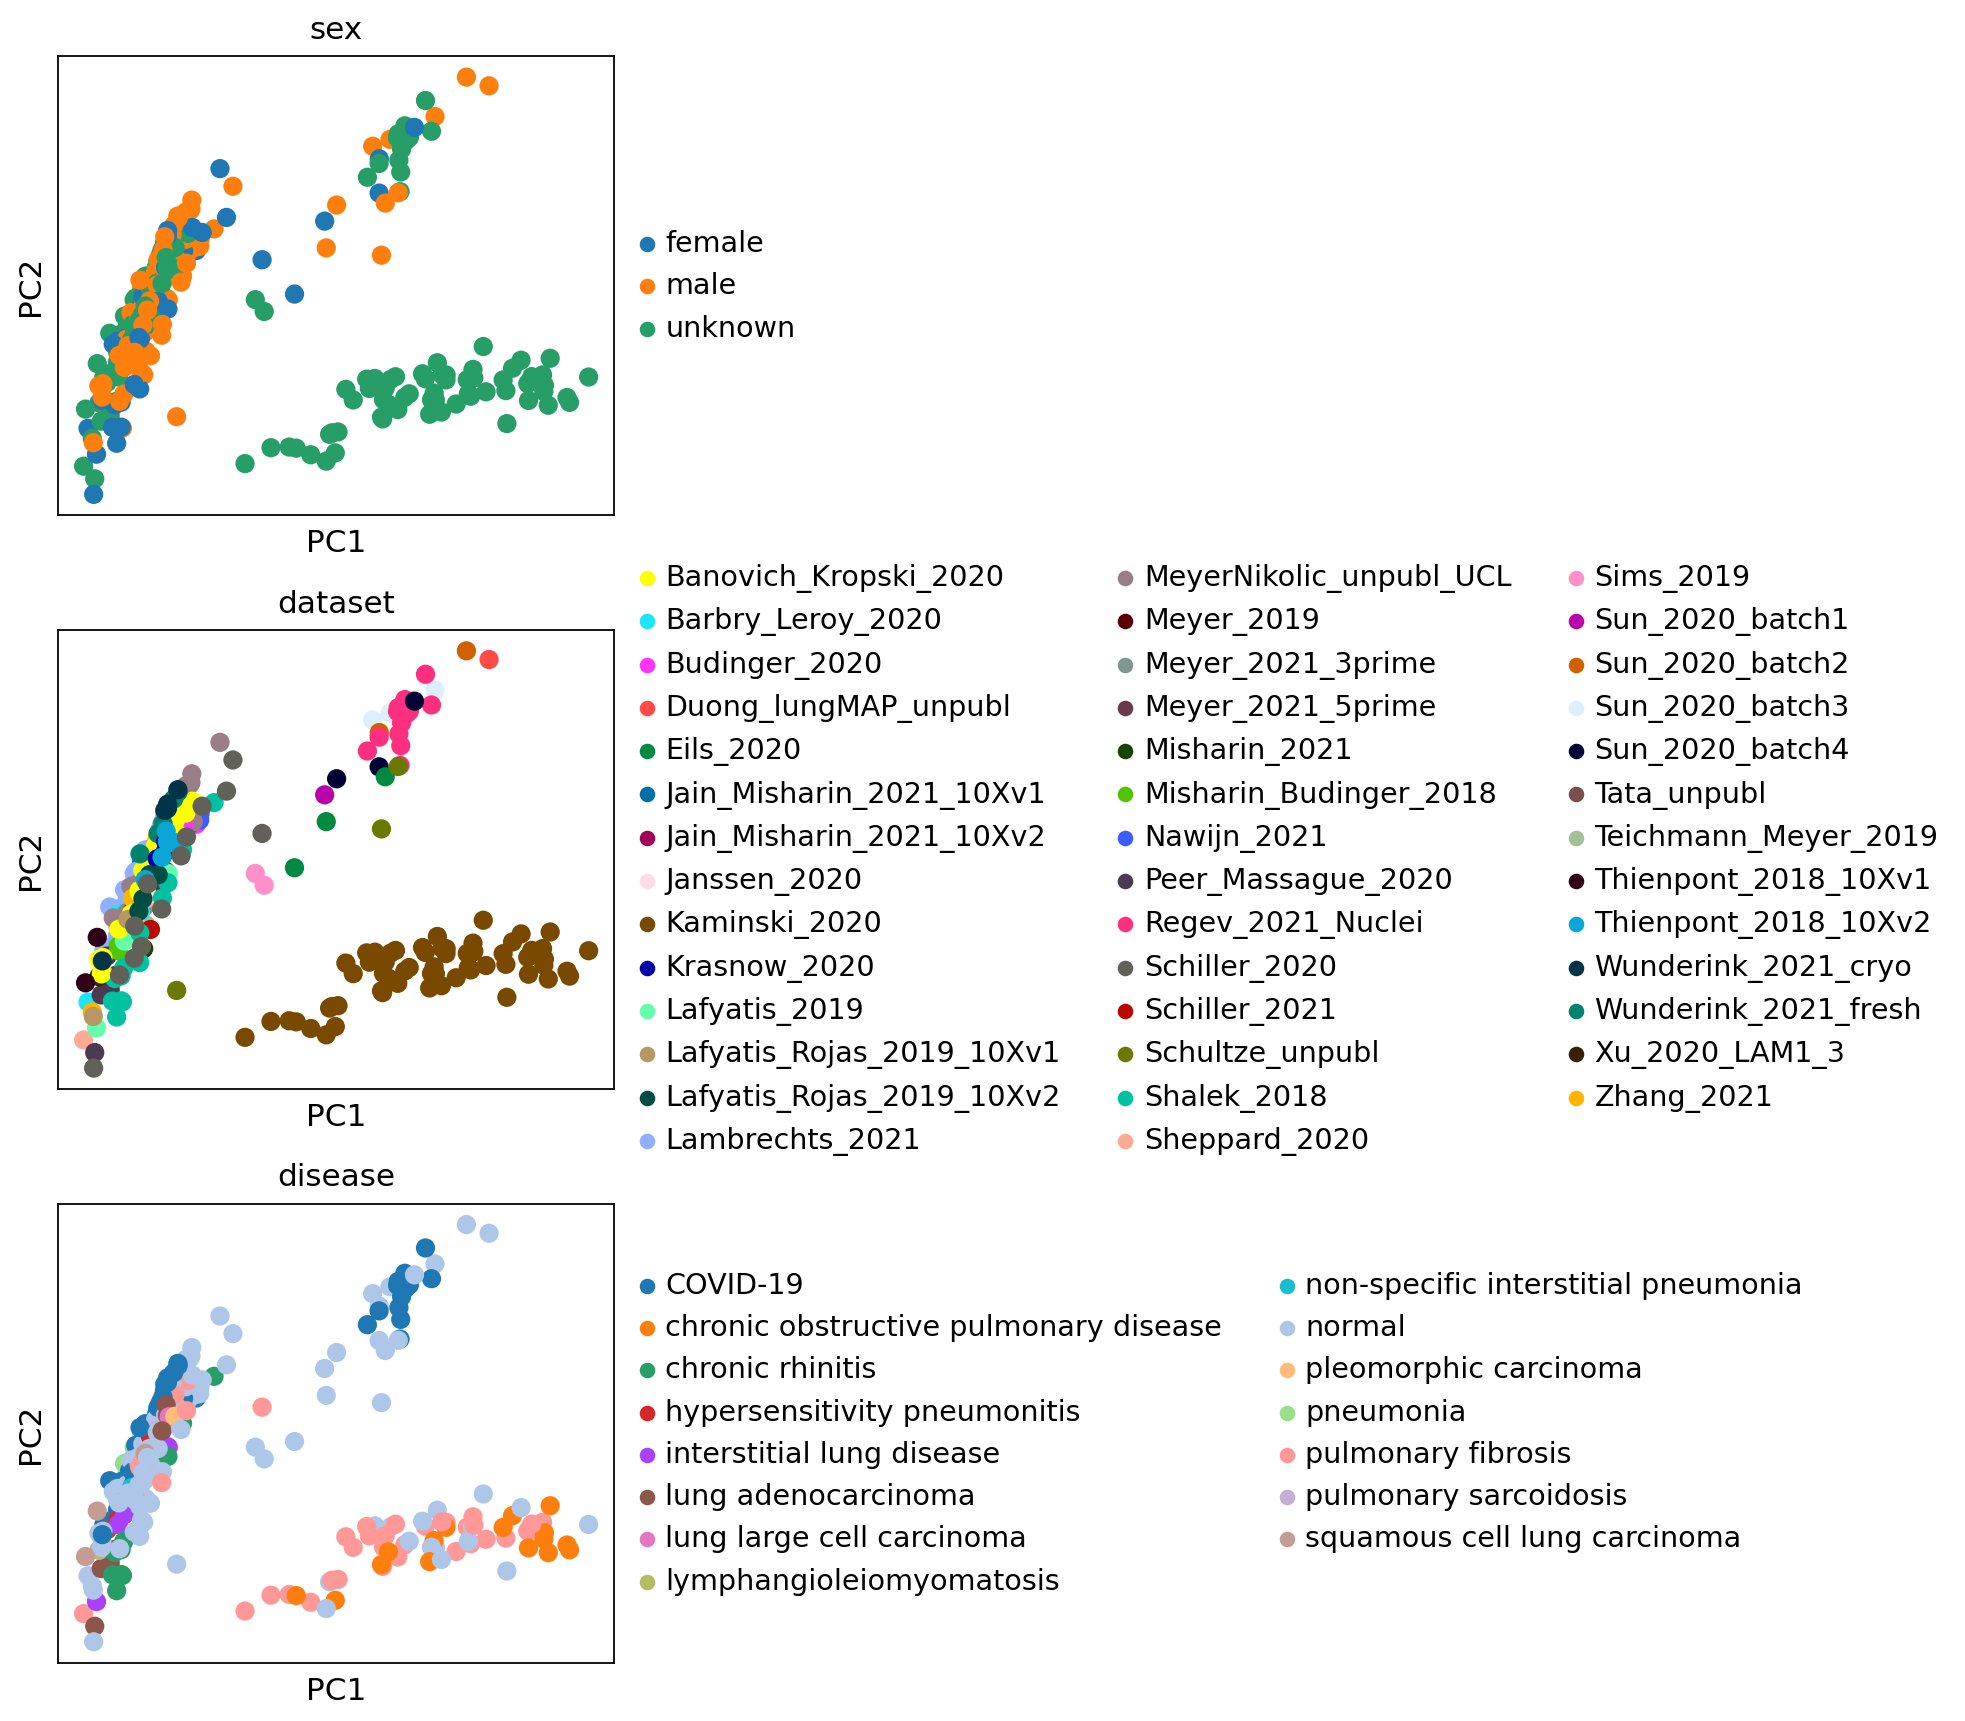

In [ ]:
pp_pdata = pdata.copy()
sc.pp.normalize_total(pp_pdata, target_sum=1e6)
sc.pp.log1p(pp_pdata)
sc.pp.scale(pp_pdata, max_value=10)
sc.tl.pca(pp_pdata, n_comps=10)
sc.pl.pca(pp_pdata, color=['sex', 'dataset', 'disease'], ncols=1, show=True, size=300)

In [ ]:
pdata.obs['disease'].value_counts()

normal                                   155
COVID-19                                  50
pulmonary fibrosis                        44
chronic obstructive pulmonary disease     16
lung adenocarcinoma                       11
chronic rhinitis                          10
pneumonia                                  5
interstitial lung disease                  5
squamous cell lung carcinoma               3
hypersensitivity pneumonitis               2
lymphangioleiomyomatosis                   2
pulmonary sarcoidosis                      1
non-specific interstitial pneumonia        1
lung large cell carcinoma                  1
pleomorphic carcinoma                      1
Name: disease, dtype: int64

In [ ]:
# Obtain genes that pass the thresholds

genes = dc.filter_by_expr(pdata, group='sex', min_count=2, min_total_count=15)

# Filter by these genes
pdatas = pdata[:, genes].copy()
pdatas, pdatas[:, 'XIST']

disease = 'COVID-19' #'pulmonary fibrosis'
pdatas = pdatas[pdata.obs['disease'].isin([disease, 'normal'])].copy()

In [ ]:
pdatas

AnnData object with n_obs × n_vars = 205 × 10017
    obs: 'suspension_type', 'donor_id', 'is_primary_data', 'assay_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'organism_ontology_term_id', 'sex_ontology_term_id', "3'_or_5'", 'BMI', 'age_or_mean_of_age_range', 'age_range', 'ann_level_1', 'ann_level_2', 'cause_of_death', 'core_or_extension', 'dataset', 'fresh_or_frozen', 'mixed_ancestry', 'sequencing_platform', 'smoking_status', 'study', 'subject_type', 'tissue_dissociation_protocol', 'transf_ann_level_1_label', 'transf_ann_level_2_label', 'assay', 'disease', 'organism', 'sex', 'self_reported_ethnicity', 'development_stage', 'batch', 'psbulk_n_cells', 'psbulk_counts'
    var: 'feature_is_filtered', 'original_gene_symbols', 'feature_name', 'feature_reference', 'feature_biotype'
    layers: 'psbulk_props'

In [ ]:
# Import DESeq2
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats

In [ ]:
import decoupler as dc

# Get pseudo-bulk profile
pdata = dc.get_pseudobulk(
    raw_tregs,
    sample_col='batch',
    groups_col=None,
    mode='sum',
    min_cells=10,
    min_counts=1000,
)
pdata

# Obtain genes that pass the thresholds

genes = dc.filter_by_expr(pdata, group='sex', min_count=2, min_total_count=15)

# Filter by these genes
pdatas = pdata[:, genes].copy()

disease = 'COVID-19' #'pulmonary fibrosis'
pdatas = pdatas[pdata.obs['disease'].isin([disease, 'normal'])].copy()

# Build DESeq2 object
dds = DeseqDataSet(
    adata=pdatas,
    design_factors=['disease', 'sex', 'assay'], #, 'dataset', 
    refit_cooks=True,
    n_cpus=8,
)

# Compute LFCs
dds.deseq2()
stat_res = DeseqStats(dds, contrast=["disease", disease, 'normal'], n_cpus=8)

In [ ]:
# Compute Wald test
stat_res.summary()
# Extract results
results_df = stat_res.results_df
results_df

Log2 fold change & Wald test p-value: disease COVID-19 vs normal


baseMean  log2FoldChange     lfcSE      stat        pvalue  \
feature_name                                                                
A1BG           4.974161       -0.606035  0.227543 -2.663385  7.735885e-03   
A2M            8.348769       -3.156780  0.603816 -5.228047  1.713096e-07   
A2M-AS1        2.248167        0.380905  0.457562  0.832466  4.051459e-01   
A2MP1          1.340328       -2.655935  1.376025 -1.930150  5.358821e-02   
AAAS           2.371162       -0.465844  0.158076 -2.946967  3.209077e-03   
...                 ...             ...       ...       ...           ...   
ZWILCH         1.480450        0.367165  0.246179  1.491454  1.358424e-01   
ZXDC           4.383156       -0.124916  0.330758 -0.377667  7.056783e-01   
ZYG11B         2.267805       -0.489981  0.303030 -1.616942  1.058909e-01   
ZZEF1         10.019056       -0.007297  0.234157 -0.031161  9.751412e-01   
ZZZ3           8.850186       -0.058235  0.316239 -0.184147  8.538978e-01   

                  padj  
feature_name            
A1BG          0.040084  
A2M           0.000008  
A2M-AS1       0.584549  
A2MP1         0.154147  
AAAS          0.020994  
...                ...  
ZWILCH        0.284823  
ZXDC          0.827643  
ZYG11B        0.242666  
ZZEF1         0.985572  
ZZZ3          0.922515  

[10017 rows x 6 columns]

baseMean  log2FoldChange     lfcSE      stat        pvalue  \
feature_name                                                                
A1BG           4.974161       -0.606035  0.227543 -2.663385  7.735885e-03   
A2M            8.348769       -3.156780  0.603816 -5.228047  1.713096e-07   
A2M-AS1        2.248167        0.380905  0.457562  0.832466  4.051459e-01   
A2MP1          1.340328       -2.655935  1.376025 -1.930150  5.358821e-02   
AAAS           2.371162       -0.465844  0.158076 -2.946967  3.209077e-03   
...                 ...             ...       ...       ...           ...   
ZWILCH         1.480450        0.367165  0.246179  1.491454  1.358424e-01   
ZXDC           4.383156       -0.124916  0.330758 -0.377667  7.056783e-01   
ZYG11B         2.267805       -0.489981  0.303030 -1.616942  1.058909e-01   
ZZEF1         10.019056       -0.007297  0.234157 -0.031161  9.751412e-01   
ZZZ3           8.850186       -0.058235  0.316239 -0.184147  8.538978e-01   

                  padj  
feature_name            
A1BG          0.040084  
A2M           0.000008  
A2M-AS1       0.584549  
A2MP1         0.154147  
AAAS          0.020994  
...                ...  
ZWILCH        0.284823  
ZXDC          0.827643  
ZYG11B        0.242666  
ZZEF1         0.985572  
ZZZ3          0.922515  

[10017 rows x 6 columns]

In [ ]:
import adjustText as at

def filter_limits(df, sign_limit=None, lFCs_limit=None):

    # Define limits if not defined
    if sign_limit is None:
        sign_limit = np.inf
    if lFCs_limit is None:
        lFCs_limit = np.inf

    # Filter by absolute value limits
    if sign_limit is not None:
        df.loc[df['pvals'] > sign_limit, 'pvals'] = 0.99 * sign_limit
    if lFCs_limit is not None:
        df.loc[np.abs(df['logFCs']) > lFCs_limit, 'logFCs'] = 0.99 * np.sign(df.loc[np.abs(df['logFCs']) > lFCs_limit, 'logFCs']) * lFCs_limit

    return df

def plot_volcano_selected(data, x, y, genes, sign_thr=0.05, lFCs_thr=0.5, sign_limit=3, lFCs_limit=3,
                    figsize=(7, 5), dpi=100, ax=None, return_fig=False, save=None):
    """
    Plot logFC and p-values from a long formated data-frame.
    Parameters
    ----------
    data : pd.DataFrame
        Results of DEA in long format.
    x : str
        Column name of data storing the logFCs.
    y : str
        Columns name of data storing the p-values.
    top : int
    """
    # Transform sign_thr
    sign_thr = -np.log10(sign_thr)

    # Extract df
    df = data.copy()
    df['logFCs'] = df[x]
    df['pvals'] = -np.log10(df[y])

    # Filter by limits
    df = filter_limits(df, sign_limit=sign_limit, lFCs_limit=lFCs_limit)
    
    df['weight'] = 'gray'
    up_msk = (df['logFCs'] >= lFCs_thr) & (df['pvals'] >= sign_thr)
    dw_msk = (df['logFCs'] <= -lFCs_thr) & (df['pvals'] >= sign_thr)
    df.loc[up_msk, 'weight'] = '#D62728'
    df.loc[dw_msk, 'weight'] = '#1F77B4'

    # Plot
    fig = None
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
    df.plot.scatter(x='logFCs', y='pvals', c='weight', sharex=False, ax=ax, s=15, alpha=0.6, xlim=(-lFCs_limit, lFCs_limit), ylim=(-0.2, sign_limit))

    # Draw sign lines
    ax.axhline(y=sign_thr, linestyle='--', color="black")
    ax.axvline(x=lFCs_thr, linestyle='--', color="black")
    ax.axvline(x=-lFCs_thr, linestyle='--', color="black")

    # Plot top sign features
    signs = df.reindex(genes).dropna()

    # Add labels
    ax.set_ylabel('-log10(pvals)')
    texts = []
    for x, y, s in zip(signs['logFCs'], signs['pvals'], signs.index):
        texts.append(ax.text(x, y, s, size=12))
    if len(texts) > 0:
        at.adjust_text(texts, arrowprops=dict(arrowstyle='-', color='black'), ax=ax)
        
    if return_fig:
        return 

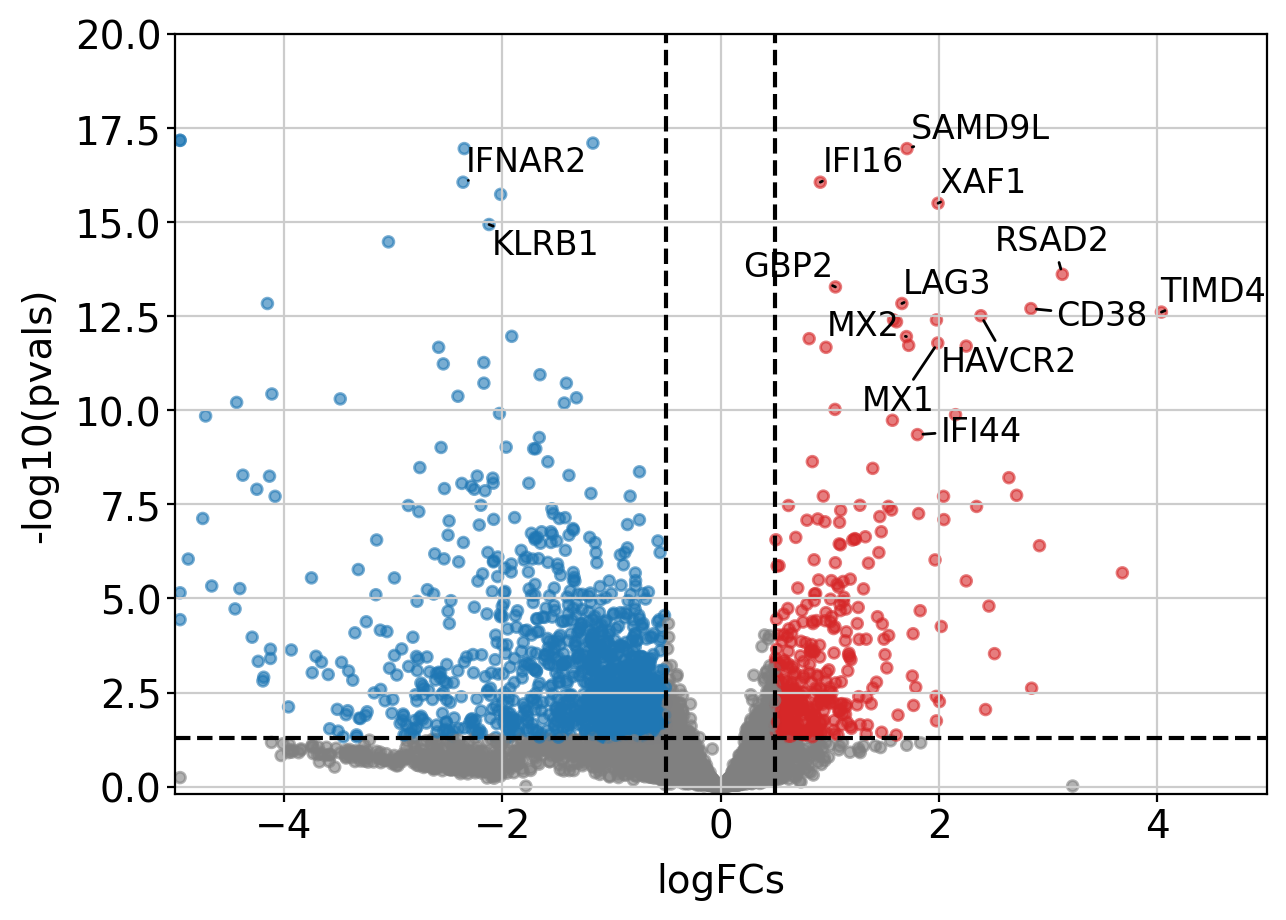

In [ ]:
results_df = stat_res.results_df
plot_volcano_selected(results_df, x='log2FoldChange', y='padj',
                      genes=['IFI16', 'LAG3', 'CD38', 'TIMD4', 'MX1', 'MX2', 'GBP2', 'HAVCR2', 'IFI44', 'IFNAR2', 'KLRB1', 'SAMD9L', 'XAF1', 'RSAD2'],
                      sign_limit=20, lFCs_limit=5)
plt.savefig('cd8_trm_covid_pseudobulk_sex.pdf')
plt.show()

## ScTriangulate consensus cell-typing

In [5]:
import scanpy as sc
import anndata
combined_data = sc.read_h5ad(f"{local_dir}/combined_data_extended_annotated.h5ad")

/home/cane/miniconda3/envs/hub_paper/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [6]:
ref_tcell = combined_data[np.logical_and(combined_data.obs['ann_level_3'].isin(['T cell lineage', 'Innate lymphoid cell NK']), combined_data.obs['batch']=='0')]
ref_tcell.obs['celltype_pred'].value_counts()

Trm_Th1/Th17               93203
Tem/emra_CD8               52067
NK_CD16+                   50805
Teffector/EM_CD4           36769
Trm/em_CD8                 20284
Tregs                      10808
T_CD4/CD8                   6644
Cycling T&NK                6386
NK_CD56bright_CD16-         4479
MAIT                        3967
Tgd_CRTAM+                  3441
Tnaive/CM_CD4               1660
Trm_gut_CD8                 1160
Tnaive/CM_CD8                817
Tfh                          619
Trm_Tgd                      473
ILC3                         446
Tnaive/CM_CD4_activated       16
Name: celltype_pred, dtype: int64

In [7]:
adata_full = sc.read_h5ad('/external_data/other/scvi-hub/scvi-hub/adata_extended2.h5ad')

In [8]:
raw_tcell = adata_full[[i[:-2] for i in ref_tcell.obs_names]].copy()

In [9]:
del adata_full
del combined_data

In [10]:
ref_tcell.obs['ann_finest_level'].value_counts()

CD8 T cells              113641
CD4 T cells               82698
NK cells                  48439
Unknown                   45358
T cells proliferating      3908
Name: ann_finest_level, dtype: int64

In [11]:
raw_tcell.obs = ref_tcell.obs
raw_tcell.obsm = ref_tcell.obsm

/home/cane/miniconda3/envs/hub_paper/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


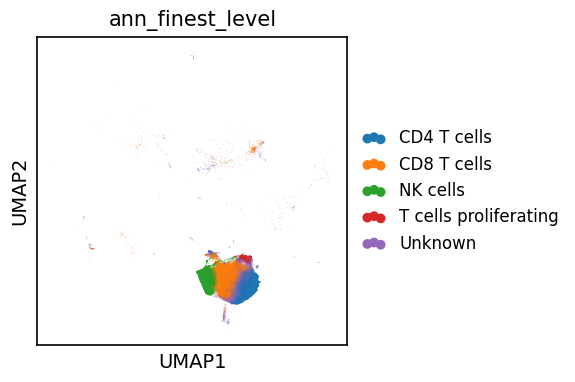

In [12]:
sc.pl.umap(raw_tcell, color='ann_finest_level')

In [13]:
import sctriangulate

2024-11-19 20:59:04.021014: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-19 20:59:04.021092: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-19 20:59:04.043534: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-19 20:59:04.777372: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [14]:
sc.pp.subsample(raw_tcell, fraction=0.1)

In [15]:
sctri = sctriangulate.ScTriangulate(dir='sctriangulate',adata=raw_tcell,query=['ann_level_3', 'celltype_pred', 'ann_finest_level'])

2024-11-19 20:59:05,914 - INFO - Choosing logging to console (VERBOSE=1)
2024-11-19 20:59:06,036 - INFO - skip scrublet doublet prediction, instead doublet is filled using value 0.5


In [27]:
sc.set_figure_params(vector_friendly=True, dpi_save=300, fontsize=14)

In [ ]:
sctri.lazy_run(assess_pruned=False,viewer_cluster=False,viewer_heterogeneity=False,reassign_abs_thresh=100)

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

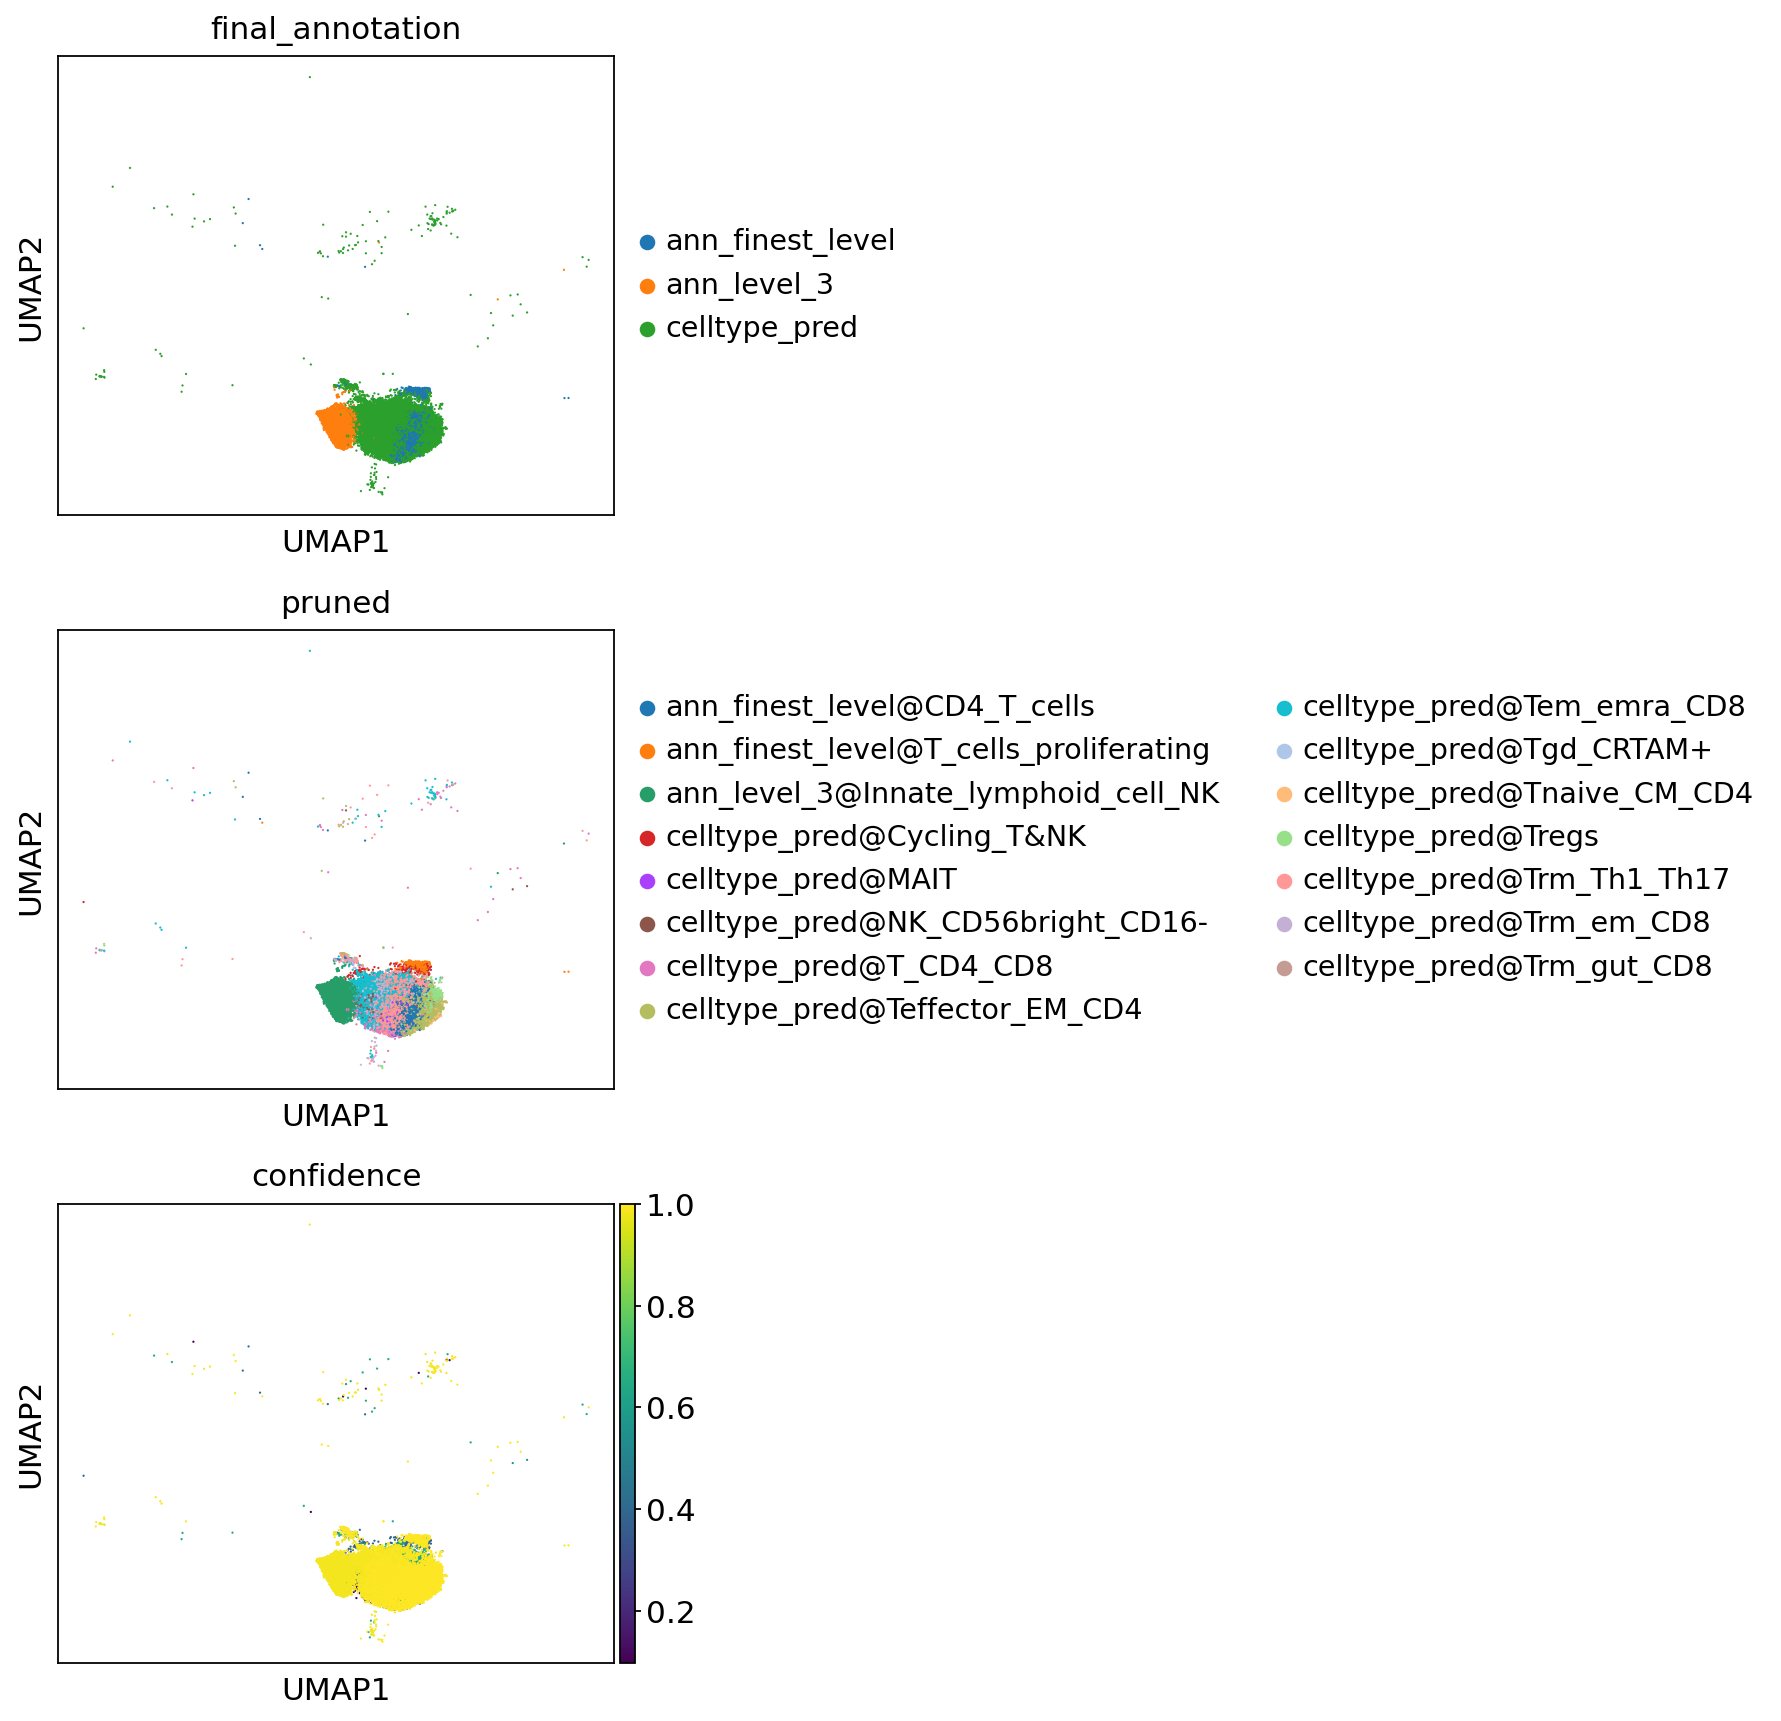

In [28]:
sc.pl.umap(sctri.adata, color=['final_annotation', 'pruned', 'confidence'], ncols=1, save='sctriangulate.svg')

In [21]:
sctri.adata.write_h5ad(f"{local_dir}/sctriangulate.h5ad")

In [22]:
sctri.adata.obs[['final_annotation', 'ann_level_3_shapley', 'celltype_pred_shapley', 'ann_finest_level_shapley', 'raw', 'prefixed', 'pruned', 'confidence', 'ori']].head(50)

final_annotation  \
GGGTTGCTCGTAGGTT-1-HCATisStab7732262-0_meyer_un...     celltype_pred   
AGGCCACCACTTAAGC_GRO-08_biopsy-0                       celltype_pred   
PP009nskept.CACATTTGTAGCGCAA-2_szabo-0                 celltype_pred   
179I_CAGAATCGTGAGTGAC_adams-0                            ann_level_3   
P3_2_TGGCTGGTCTGTACGA-0                                celltype_pred   
PP010nskept.GTCATTTAGAAGGGTA-3_szabo-0                 celltype_pred   
PP001nskept.TTCCCAGTCTTGCCGT-0_szabo-0                 celltype_pred   
098C-a_TTCGAAGTCTCAACTT_adams-0                        celltype_pred   
CTAGAGTCACGGTAGA-CV001_KM8853547-ucl_meyer_niko...     celltype_pred   
AGGTCCGTCCTCGCAT_GRO-04_biopsy-0                       celltype_pred   
17851_laughney-0                                       celltype_pred   
TGTTCATGTACACTCA-17_bharat-0                           celltype_pred   
CCCTCCTAGAGACTTA_F02526-0                              celltype_pred   
098C-a_GTGAAGGTCTACCTGC_adams-0                        celltype_pred   
CTGATCCCACGACTCG-1-HCATisStab7732263-0_meyer_un...     celltype_pred   
TCATTACCAGGTCGTC-CV001_KM8853596-ucl_meyer_niko...     celltype_pred   
184CO-b_TGTGGTAGTCTTGCGG_adams-0                         ann_level_3   
CTGAAGTAGATGTCGG-18_grant_cryo-0                       celltype_pred   
003C_GGATGTTTCGCGATCG_adams-0                          celltype_pred   
GACGCGTTCGCCGTGA-16_grant_cryo-0                       celltype_pred   
PP001nskept.ATCACGAAGATACACA-0_szabo-0                 celltype_pred   
ACGATGACTTTCTG-SC31D-0                              ann_finest_level   
CATCAAGGTAAAGTCA-CV001_KM9166350-ucl_meyer_niko...     celltype_pred   
BT1291_TCATTTGTCCCTTGTG_lambrechts-0                   celltype_pred   
BT1298_GGAAAGCGTTGACGTT_lambrechts-0                   celltype_pred   
166I-a_CGGAGCTTCGAGAGCA_adams-0                        celltype_pred   
TGCGCAGCACGAAATA-1-WTDAtest7732265-0_meyer_unpu...     celltype_pred   
scrBT1426_CATATGGTCTTGGGTA_lambrechts-0                celltype_pred   
Pool_425_GAGGCCGTAAAG_schultze_unpubl-0                celltype_pred   
034C_ACAGCTAGTGGCAAAC_adams-0                            ann_level_3   
02-P334354-S087-R01-TTACCGCCAATGGCAG_delorey_nu...     celltype_pred   
TATTACCTCGTTGCCT-1-HCATisStab7587202-0                 celltype_pred   
P3_7_CCCATACCACAAGTAA-0                             ann_finest_level   
AGATCAGAAGCAC_GRO-04_biopsy-0                       ann_finest_level   
38313_laughney-0                                       celltype_pred   
GATCGATGTTCTCATT-WSSS_A_LNG8620063-0_meyer_unpu...     celltype_pred   
Valenzi_SSc7_GTCGTAAAGCTAGGCA_valenzi-0             ann_finest_level   
5928_laughney-0                                        celltype_pred   
5769_laughney-0                                        celltype_pred   
439C_TGGGAAGGTACTCTCC_adams-0                          celltype_pred   
GACTGCGTCCCTAACC_SCD1_tsukui-0                         celltype_pred   
CCGTGGATCAGGTAAA_HD67-0                             ann_finest_level   
022C-b_CTAAGACTCTGGCGTG_adams-0                        celltype_pred   
098C-b_GGACGTCTCACGAAGG_adams-0                        celltype_pred   
PP009nskept.GGACAGAGTGAACCTT-2_szabo-0                 celltype_pred   
439C-b_GTTACAGAGTGCCAGA_adams-0                        celltype_pred   
CAAGAAATCTGTTTGT-WSSS_A_LNG8620062-0_meyer_unpu...     celltype_pred   
178CO_TCAGGATGTCACTTCC_adams-0                         celltype_pred   
GATCGTAGTGACTGTT-19_bharat-0                           celltype_pred   
BT1293_ATTATCCTCGCTTGTC_lambrechts-0                     ann_level_3   

                                                    ann_level_3_shapley  \
GGGTTGCTCGTAGGTT-1-HCATisStab7732262-0_meyer_un...             3.333333   
AGGCCACCACTTAAGC_GRO-08_biopsy-0                               3.333333   
PP009nskept.CACATTTGTAGCGCAA-2_szabo-0                         3.333333   
179I_CAGAATCGTGAGTGAC_adams-0                                  6.666667   
P3_2

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

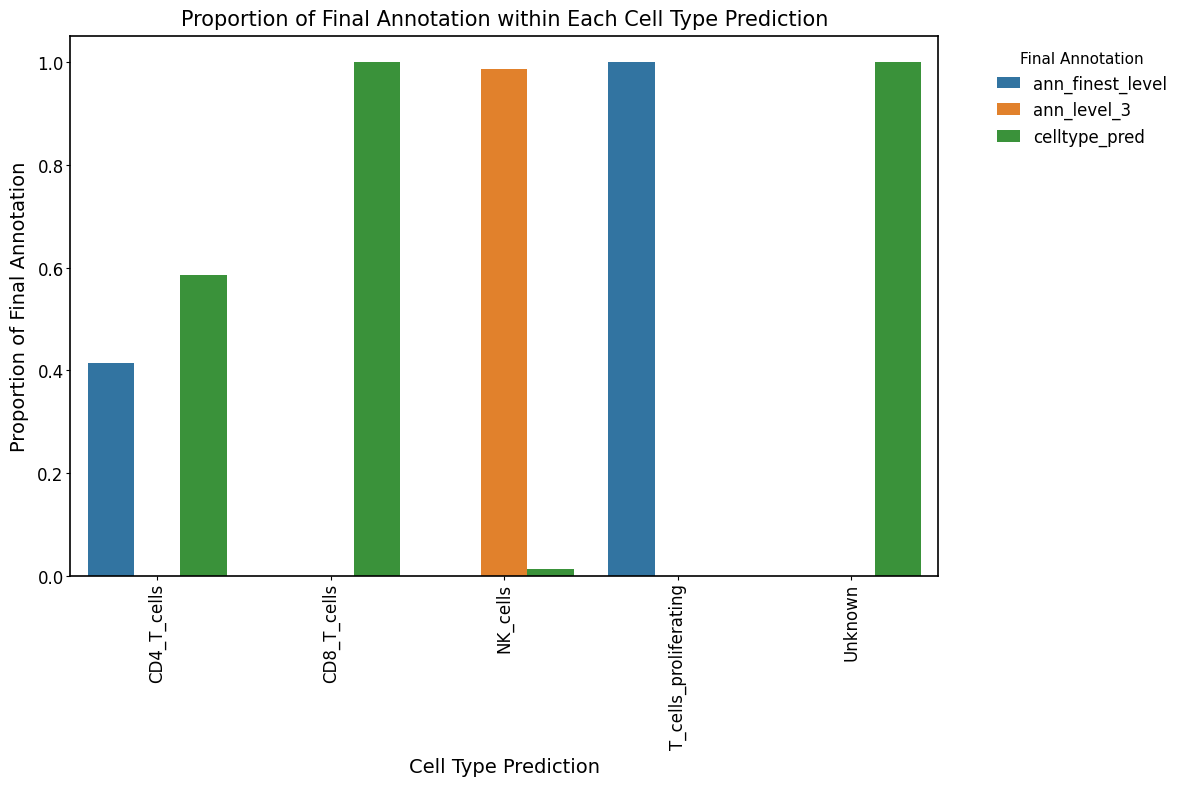

In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming sctri.adata.obs is a DataFrame
df = sctri.adata.obs[['final_annotation', 'ann_finest_level']]

# Calculate the proportion of final_annotation within each celltype_pred_shapley
proportions = df.groupby(['ann_finest_level', 'final_annotation']).size().reset_index(name='count')
proportions['proportion'] = proportions.groupby('ann_finest_level')['count'].transform(lambda x: x / x.sum())

# Create the bar plot
plt.figure(figsize=(12, 8))
sns.barplot(x='ann_finest_level', y='proportion', hue='final_annotation', data=proportions)
plt.xticks(rotation=90)
plt.xlabel('Cell Type Prediction')
plt.ylabel('Proportion of Final Annotation')
plt.title('Proportion of Final Annotation within Each Cell Type Prediction')
plt.legend(title='Final Annotation', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [32]:
pd.options.display.max_rows = 1000

In [34]:
sctri.adata[sctri.adata.obs['celltype_pred']=='Tfh'].obs['raw']

scrBT1431_TCGGGACAGAGTCTGG_lambrechts-0                  celltype_pred@Tfh
192CO-a_CTGATCCCACGGATAG_adams-0                         celltype_pred@Tfh
38802_laughney-0                                         celltype_pred@Tfh
BT1300_GCTTGAACAGCTCGCA_lambrechts-0                     celltype_pred@Tfh
BT1244_ACGCCACTACCTAG_lambrechts-0                       celltype_pred@Tfh
42639_laughney-0                                         celltype_pred@Tfh
AACCACAGTAACATGA-1_DD073R_tata_unpubl-0                  celltype_pred@Tfh
034I-a_ATAGACCGTATAGGTA_adams-0                          celltype_pred@Tfh
BT1247_TACGCCACTCTTAC_lambrechts-0                       celltype_pred@Tfh
BT1301_GTTCTCGGTTGCGTTA_lambrechts-0                     celltype_pred@Tfh
02-P348762-S056-R01-TGCAGGCAGCGTGAAC_delorey_nuclei-0    celltype_pred@Tfh
38440_laughney-0                                         celltype_pred@Tfh
scrBT1431_TGGCGCAAGCCGATTT_lambrechts-0                  celltype_pred@Tfh
scrBT1432_GCTGCTTGTGTAATG

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

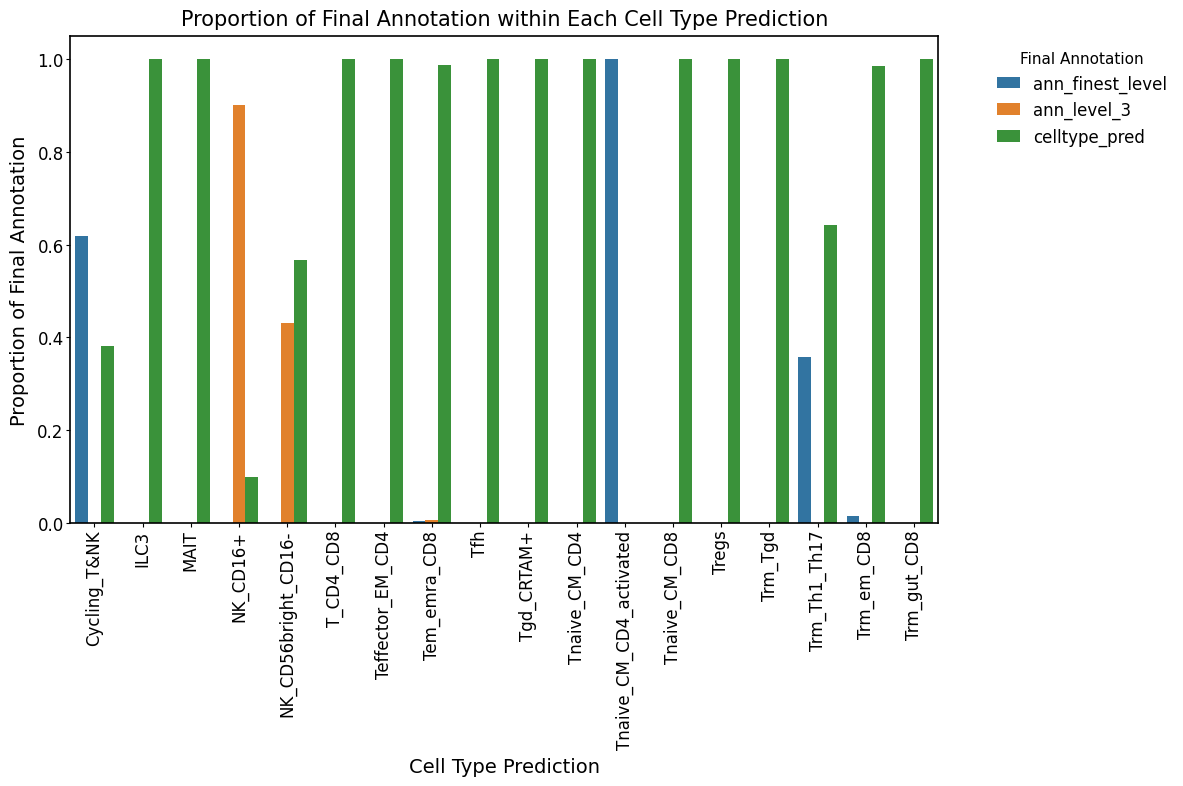

In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming sctri.adata.obs is a DataFrame
df = sctri.adata.obs[['final_annotation', 'celltype_pred']]

# Calculate the proportion of final_annotation within each celltype_pred_shapley
proportions = df.groupby(['celltype_pred', 'final_annotation']).size().reset_index(name='count')
proportions['proportion'] = proportions.groupby('celltype_pred')['count'].transform(lambda x: x / x.sum())

# Create the bar plot
plt.figure(figsize=(12, 8))
sns.barplot(x='celltype_pred', y='proportion', hue='final_annotation', data=proportions)
plt.xticks(rotation=90)
plt.xlabel('Cell Type Prediction')
plt.ylabel('Proportion of Final Annotation')
plt.title('Proportion of Final Annotation within Each Cell Type Prediction')
plt.legend(title='Final Annotation', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig('celltype_pred_final_annotation_proportion.svg')
plt.tight_layout()
plt.show()